# AMMICO Demonstration Notebook
With ammico, you can analyze text on images and image content at the same time. This is a demonstration notebook to showcase the capabilities of ammico.
You can run this notebook on google colab or locally / on your own HPC resource. The first cell only runs on google colab; on all other machines, you need to create a conda environment first and install ammico from the Python Package Index using  
```pip install ammico```  
Alternatively you can install the development version from the GitHub repository  
```pip install git+https://github.com/ssciwr/AMMICO.git```

In [1]:
# if running on google colab
# flake8-noqa-cell

if "google.colab" in str(get_ipython()):
    # update python version
    # install setuptools
    # %pip install setuptools==61 -qqq
    # uninstall some pre-installed packages due to incompatibility
    %pip uninstall tensorflow-probability dopamine-rl lida pandas-gbq torchaudio torchdata torchtext orbax-checkpoint flex-y -qqq
    # install ammico
    %pip install git+https://github.com/ssciwr/ammico.git -qqq
    # mount google drive for data and API key
    from google.colab import drive

    drive.mount("/content/drive")

## Use a test dataset
You can download a dataset for test purposes. Skip this step if you use your own data.

In [2]:
from datasets import load_dataset
from pathlib import Path

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("iulusoy/test-images")

/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 6 examples [00:00, 423.54 examples/s]

Next you need to provide a path for the saved images - a folder where the data is stored locally. This directory is automatically created if it does not exist.

In [3]:
data_path = "./data-test"
data_path = Path(data_path)
data_path.mkdir(parents=True, exist_ok=True)
# now save the files from the Huggingface dataset as images into the data_path folder
for i, image in enumerate(dataset["train"]["image"]):
    filename = "img" + str(i) + ".png"
    image.save(data_path / filename)

## Import the ammico package.

In [4]:
import os
import ammico
# for displaying a progress bar
from tqdm import tqdm

Sometimes you may need to restart a session after installing the correct versions of packages, because `Tensorflow` and `EmotitionDetector` may not work and give an error. You can check it by running this code: 
```
import tensorflow as tf
tf.ones([2, 2])
```
If this code generates an error, you need to restart session. For this please click `Runtime` -> `Restart session`. And rerun the notebook again. All required packages will already be installed, so the execution will be very fast. 

# Step 0: Create and set a Google Cloud Vision Key

Please note that for the [Google Cloud Vision API](https://cloud.google.com/vision/docs/setup) (the TextDetector class) you need to set a key in order to process the images. A key is generated following [these instructions](../set_up_credentials.md). This key is ideally set as an environment variable using for example
```
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"
] = "/content/drive/MyDrive/misinformation-data/misinformation-campaign-981aa55a3b13.json"
```
where you place the key on your Google Drive if running on colab, or place it in a local folder on your machine.

In [5]:
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/misinformation-data/misinformation-campaign-981aa55a3b13.json"

# Step 1: Read your data into AMMICO
The ammico package reads in one or several input files given in a folder for processing. The user can select to read in all image files in a folder, to include subfolders via the `recursive` option, and can select the file extension that should be considered (for example, only "jpg" files, or both "jpg" and "png" files). For reading in the files, the ammico function `find_files` is used, with optional keywords:

| input key | input type | possible input values |
| --------- | ---------- | --------------------- |
`path` | `str` | the directory containing the image files (defaults to the location set by environment variable `AMMICO_DATA_HOME`) |
| `pattern` | `str\|list` | the file extensions to consider (defaults to "png", "jpg", "jpeg", "gif", "webp", "avif", "tiff") |
| `recursive` | `bool` | include subdirectories recursively (defaults to `True`) |
| `limit` | `int` | maximum number of files to read (defaults to `20`, for all images set to `None` or `-1`) |
| `random_seed` | `str` | the random seed for shuffling the images; applies when only a few images are read and the selection should be preserved (defaults to `None`) |

The `find_files` function returns a nested dict that contains the file ids and the paths to the files and is empty otherwise. This dict is filled step by step with more data as each detector class is run on the data (see below).

If you downloaded the test dataset above, you can directly provide the path you already set for the test directory, `data_path`.

In [6]:
image_dict = ammico.find_files(
    # path="/content/drive/MyDrive/misinformation-data/",
    path=data_path.as_posix(),
    limit=15,
)

## Step 2: Inspect the input files using the graphical user interface
A Dash user interface is to select the most suitable options for the analysis, before running a complete analysis on the whole data set. The options for each detector module are explained below in the corresponding sections; for example, different models can be selected that will provide slightly different results. This way, the user can interactively explore which settings provide the most accurate results. In the interface, the nested `image_dict` is passed through the `AnalysisExplorer` class. The interface is run on a specific port which is passed using the `port` keyword; if a port is already in use, it will return an error message, in which case the user should select a different port number. 
The interface opens a dash app inside the Jupyter Notebook and allows selection of the input file in the top left dropdown menu, as well as selection of the detector type in the top right, with options for each detector type as explained below. The output of the detector is shown directly on the right next to the image. This way, the user can directly inspect how updating the options for each detector changes the computed results, and find the best settings for a production run.

In [7]:
analysis_explorer = ammico.AnalysisExplorer(image_dict)
analysis_explorer.run_server(port=8055)

## Step 3: Analyze all images
The analysis can be run in production on all images in the data set. Depending on the size of the data set and the computing resources available, this can take some time. 

It is also possible to set the dump file  creation `dump_file` in order to save the calculated data every `dump_every` images. 

In [8]:
# dump file name
dump_file = "dump_file.csv"
# dump every N images 
dump_every = 10

The desired detector modules are called sequentially in any order, for example the `EmotionDetector`:

In [9]:
for num, key in tqdm(enumerate(image_dict.keys()), total=len(image_dict)):    # loop through all images
    image_dict[key] = ammico.EmotionDetector(image_dict[key]).analyse_image() # analyse image with EmotionDetector and update dict
    
    if num % dump_every == 0 or num == len(image_dict) - 1:      # save results every dump_every to dump_file
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:08<00:41,  8.32s/it]

Found missing key(s) {'no_faces', 'age', 'wears_mask', 'emotion (category)', 'multiple_faces', 'emotion', 'gender', 'race', 'face'} in subdict img1 - setting to None.
Found missing key(s) {'no_faces', 'age', 'wears_mask', 'emotion (category)', 'multiple_faces', 'emotion', 'gender', 'race', 'face'} in subdict img2 - setting to None.
Found missing key(s) {'no_faces', 'age', 'wears_mask', 'emotion (category)', 'multiple_faces', 'emotion', 'gender', 'race', 'face'} in subdict img3 - setting to None.
Found missing key(s) {'no_faces', 'age', 'wears_mask', 'emotion (category)', 'multiple_faces', 'emotion', 'gender', 'race', 'face'} in subdict img0 - setting to None.
Found missing key(s) {'no_faces', 'age', 'wears_mask', 'emotion (category)', 'multiple_faces', 'emotion', 'gender', 'race', 'face'} in subdict img5 - setting to None.


 33%|███▎      | 2/6 [00:10<00:19,  4.89s/it]

 50%|█████     | 3/6 [00:13<00:11,  3.70s/it]

 67%|██████▋   | 4/6 [00:15<00:06,  3.14s/it]

 83%|████████▎ | 5/6 [00:17<00:02,  2.82s/it]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 523ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 62ms/step


100%|██████████| 6/6 [01:02<00:00, 17.17s/it]

100%|██████████| 6/6 [01:02<00:00, 10.44s/it]

`TextDetector`:

In [10]:
for num, key in tqdm(enumerate(image_dict.keys()), total=len(image_dict)):  # loop through all images
    image_dict[key] = ammico.TextDetector(image_dict[key], analyse_text=True).analyse_image() # analyse image with EmotionDetector and update dict
    
    if num % dump_every == 0 | num == len(image_dict) - 1:     # save results every dump_every to dump_file
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0/6 [00:00<?, ?it/s]

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/42.8 MB 23.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 19.3/42.8 MB 92.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 42.8/42.8 MB 145.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 60.8 MB/s eta 0:00:00


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

config.json: 100%|██████████| 1.80k/1.80k [00:00<00:00, 731kB/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   2%|▏         | 21.0M/1.22G [00:00<00:08, 142MB/s]

pytorch_model.bin:   3%|▎         | 41.9M/1.22G [00:00<00:06, 175MB/s]

pytorch_model.bin:   6%|▌         | 73.4M/1.22G [00:00<00:05, 193MB/s]

pytorch_model.bin:   8%|▊         | 94.4M/1.22G [00:00<00:05, 198MB/s]

pytorch_model.bin:   9%|▉         | 115M/1.22G [00:00<00:05, 198MB/s] 

pytorch_model.bin:  11%|█         | 136M/1.22G [00:00<00:05, 201MB/s]

pytorch_model.bin:  13%|█▎        | 157M/1.22G [00:00<00:05, 201MB/s]

pytorch_model.bin:  15%|█▍        | 178M/1.22G [00:00<00:05, 202MB/s]

pytorch_model.bin:  16%|█▋        | 199M/1.22G [00:01<00:05, 204MB/s]

pytorch_model.bin:  18%|█▊        | 220M/1.22G [00:01<00:04, 202MB/s]

pytorch_model.bin:  20%|█▉        | 241M/1.22G [00:01<00:04, 202MB/s]

pytorch_model.bin:  21%|██▏       | 262M/1.22G [00:01<00:04, 204MB/s]

pytorch_model.bin:  23%|██▎       | 283M/1.22G [00:01<00:04, 204MB/s]

pytorch_model.bin:  25%|██▍       | 304M/1.22G [00:01<00:04, 202MB/s]

pytorch_model.bin:  27%|██▋       | 325M/1.22G [00:01<00:04, 201MB/s]

pytorch_model.bin:  28%|██▊       | 346M/1.22G [00:01<00:04, 201MB/s]

pytorch_model.bin:  30%|███       | 367M/1.22G [00:01<00:04, 202MB/s]

pytorch_model.bin:  32%|███▏      | 388M/1.22G [00:01<00:04, 202MB/s]

pytorch_model.bin:  34%|███▍      | 419M/1.22G [00:02<00:03, 206MB/s]

pytorch_model.bin:  37%|███▋      | 451M/1.22G [00:02<00:03, 205MB/s]

pytorch_model.bin:  39%|███▊      | 472M/1.22G [00:02<00:03, 205MB/s]

pytorch_model.bin:  40%|████      | 493M/1.22G [00:02<00:03, 203MB/s]

pytorch_model.bin:  42%|████▏     | 514M/1.22G [00:02<00:03, 204MB/s]

pytorch_model.bin:  44%|████▍     | 535M/1.22G [00:03<00:15, 43.7MB/s]

pytorch_model.bin:  45%|████▌     | 556M/1.22G [00:04<00:12, 52.3MB/s]

pytorch_model.bin:  47%|████▋     | 577M/1.22G [00:04<00:10, 64.2MB/s]

pytorch_model.bin:  49%|████▉     | 598M/1.22G [00:04<00:08, 77.1MB/s]

pytorch_model.bin:  51%|█████     | 619M/1.22G [00:04<00:06, 90.7MB/s]

pytorch_model.bin:  52%|█████▏    | 640M/1.22G [00:06<00:16, 36.3MB/s]

pytorch_model.bin:  54%|█████▍    | 661M/1.22G [00:07<00:21, 25.7MB/s]

pytorch_model.bin:  56%|█████▌    | 682M/1.22G [00:07<00:16, 33.7MB/s]

pytorch_model.bin:  57%|█████▋    | 703M/1.22G [00:07<00:11, 44.7MB/s]

pytorch_model.bin:  59%|█████▉    | 724M/1.22G [00:07<00:08, 58.4MB/s]

pytorch_model.bin:  61%|██████    | 744M/1.22G [00:07<00:06, 74.2MB/s]

pytorch_model.bin:  63%|██████▎   | 765M/1.22G [00:07<00:04, 91.5MB/s]

pytorch_model.bin:  64%|██████▍   | 786M/1.22G [00:08<00:03, 110MB/s] 

pytorch_model.bin:  66%|██████▌   | 807M/1.22G [00:08<00:03, 128MB/s]

pytorch_model.bin:  68%|██████▊   | 828M/1.22G [00:08<00:02, 143MB/s]

pytorch_model.bin:  69%|██████▉   | 849M/1.22G [00:08<00:02, 156MB/s]

pytorch_model.bin:  71%|███████   | 870M/1.22G [00:08<00:02, 160MB/s]

pytorch_model.bin:  73%|███████▎  | 891M/1.22G [00:08<00:01, 170MB/s]

pytorch_model.bin:  75%|███████▍  | 912M/1.22G [00:08<00:01, 174MB/s]

pytorch_model.bin:  76%|███████▋  | 933M/1.22G [00:08<00:01, 179MB/s]

pytorch_model.bin:  78%|███████▊  | 954M/1.22G [00:08<00:01, 184MB/s]

pytorch_model.bin:  80%|███████▉  | 975M/1.22G [00:09<00:01, 188MB/s]

pytorch_model.bin:  81%|████████▏ | 996M/1.22G [00:10<00:05, 39.7MB/s]

pytorch_model.bin:  83%|████████▎ | 1.02G/1.22G [00:10<00:04, 50.2MB/s]

pytorch_model.bin:  85%|████████▍ | 1.04G/1.22G [00:10<00:02, 62.7MB/s]

pytorch_model.bin:  87%|████████▋ | 1.06G/1.22G [00:11<00:02, 76.5MB/s]

pytorch_model.bin:  88%|████████▊ | 1.08G/1.22G [00:11<00:01, 91.4MB/s]

pytorch_model.bin:  90%|█████████ | 1.10G/1.22G [00:11<00:01, 109MB/s] 

pytorch_model.bin:  92%|█████████▏| 1.12G/1.22G [00:11<00:00, 126MB/s]

pytorch_model.bin:  94%|█████████▎| 1.14G/1.22G [00:11<00:00, 142MB/s]

pytorch_model.bin:  96%|█████████▌| 1.17G/1.22G [00:11<00:00, 163MB/s]

pytorch_model.bin:  98%|█████████▊| 1.20G/1.22G [00:11<00:00, 171MB/s]

pytorch_model.bin: 100%|██████████| 1.22G/1.22G [00:11<00:00, 182MB/s]

pytorch_model.bin: 100%|██████████| 1.22G/1.22G [00:11<00:00, 103MB/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

tokenizer_config.json: 100%|██████████| 26.0/26.0 [00:00<00:00, 31.8kB/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 4.69MB/s]

vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 4.62MB/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 2.35MB/s]

merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 2.32MB/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config.json: 100%|██████████| 629/629 [00:00<00:00, 128kB/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

pytorch_model.bin:   4%|▍         | 10.5M/268M [00:00<00:06, 42.6MB/s]

pytorch_model.bin:  16%|█▌        | 41.9M/268M [00:00<00:01, 123MB/s] 

pytorch_model.bin:  27%|██▋       | 73.4M/268M [00:00<00:01, 164MB/s]

pytorch_model.bin:  39%|███▉      | 105M/268M [00:00<00:00, 186MB/s] 

pytorch_model.bin:  51%|█████     | 136M/268M [00:00<00:00, 196MB/s]

pytorch_model.bin:  63%|██████▎   | 168M/268M [00:00<00:00, 201MB/s]

pytorch_model.bin:  70%|███████   | 189M/268M [00:01<00:00, 202MB/s]

pytorch_model.bin:  78%|███████▊  | 210M/268M [00:01<00:00, 203MB/s]

pytorch_model.bin:  90%|█████████ | 241M/268M [00:01<00:00, 206MB/s]

pytorch_model.bin: 100%|██████████| 268M/268M [00:01<00:00, 207MB/s]

pytorch_model.bin: 100%|██████████| 268M/268M [00:01<00:00, 185MB/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 52.1kB/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 43.5MB/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

config.json: 100%|██████████| 998/998 [00:00<00:00, 1.14MB/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

pytorch_model.bin:   1%|          | 10.5M/1.33G [00:00<01:11, 18.5MB/s]

pytorch_model.bin:   2%|▏         | 21.0M/1.33G [00:00<00:43, 30.5MB/s]

pytorch_model.bin:   2%|▏         | 31.5M/1.33G [00:01<00:37, 34.8MB/s]

pytorch_model.bin:   3%|▎         | 41.9M/1.33G [00:01<00:42, 30.6MB/s]

pytorch_model.bin:   4%|▍         | 52.4M/1.33G [00:01<00:33, 38.1MB/s]

pytorch_model.bin:   5%|▍         | 62.9M/1.33G [00:01<00:29, 43.4MB/s]

pytorch_model.bin:   6%|▌         | 73.4M/1.33G [00:01<00:27, 46.0MB/s]

pytorch_model.bin:   6%|▋         | 83.9M/1.33G [00:02<00:28, 44.1MB/s]

pytorch_model.bin:   7%|▋         | 94.4M/1.33G [00:02<00:27, 45.2MB/s]

pytorch_model.bin:   8%|▊         | 105M/1.33G [00:02<00:25, 47.8MB/s] 

pytorch_model.bin:   9%|▊         | 115M/1.33G [00:02<00:31, 39.3MB/s]

pytorch_model.bin:   9%|▉         | 126M/1.33G [00:03<00:29, 40.8MB/s]

pytorch_model.bin:  10%|█         | 136M/1.33G [00:03<00:26, 45.0MB/s]

pytorch_model.bin:  11%|█         | 147M/1.33G [00:03<00:27, 43.2MB/s]

pytorch_model.bin:  12%|█▏        | 157M/1.33G [00:03<00:26, 44.9MB/s]

pytorch_model.bin:  13%|█▎        | 168M/1.33G [00:04<00:26, 44.4MB/s]

pytorch_model.bin:  13%|█▎        | 178M/1.33G [00:04<00:23, 49.8MB/s]

pytorch_model.bin:  14%|█▍        | 189M/1.33G [00:04<00:22, 51.8MB/s]

pytorch_model.bin:  15%|█▍        | 199M/1.33G [00:04<00:23, 48.9MB/s]

pytorch_model.bin:  16%|█▌        | 210M/1.33G [00:04<00:22, 49.9MB/s]

pytorch_model.bin:  17%|█▋        | 220M/1.33G [00:05<00:21, 51.6MB/s]

pytorch_model.bin:  17%|█▋        | 231M/1.33G [00:05<00:24, 44.4MB/s]

pytorch_model.bin:  18%|█▊        | 241M/1.33G [00:05<00:26, 41.8MB/s]

pytorch_model.bin:  19%|█▉        | 252M/1.33G [00:05<00:27, 39.8MB/s]

pytorch_model.bin:  20%|█▉        | 262M/1.33G [00:06<00:24, 43.8MB/s]

pytorch_model.bin:  20%|██        | 273M/1.33G [00:06<00:22, 47.0MB/s]

pytorch_model.bin:  21%|██        | 283M/1.33G [00:06<00:21, 49.3MB/s]

pytorch_model.bin:  22%|██▏       | 294M/1.33G [00:06<00:24, 43.1MB/s]

pytorch_model.bin:  23%|██▎       | 304M/1.33G [00:07<00:25, 40.5MB/s]

pytorch_model.bin:  24%|██▎       | 315M/1.33G [00:07<00:24, 42.2MB/s]

pytorch_model.bin:  24%|██▍       | 325M/1.33G [00:07<00:23, 42.6MB/s]

pytorch_model.bin:  25%|██▌       | 336M/1.33G [00:07<00:23, 42.7MB/s]

pytorch_model.bin:  26%|██▌       | 346M/1.33G [00:08<00:23, 42.0MB/s]

pytorch_model.bin:  27%|██▋       | 357M/1.33G [00:08<00:23, 41.9MB/s]

pytorch_model.bin:  28%|██▊       | 367M/1.33G [00:08<00:21, 45.7MB/s]

pytorch_model.bin:  28%|██▊       | 377M/1.33G [00:08<00:26, 36.7MB/s]

pytorch_model.bin:  29%|██▉       | 388M/1.33G [00:09<00:22, 41.7MB/s]

pytorch_model.bin:  30%|██▉       | 398M/1.33G [00:09<00:21, 43.7MB/s]

pytorch_model.bin:  31%|███       | 409M/1.33G [00:09<00:22, 40.6MB/s]

pytorch_model.bin:  31%|███▏      | 419M/1.33G [00:09<00:24, 37.9MB/s]

pytorch_model.bin:  32%|███▏      | 430M/1.33G [00:10<00:21, 41.9MB/s]

pytorch_model.bin:  33%|███▎      | 440M/1.33G [00:10<00:21, 41.9MB/s]

pytorch_model.bin:  34%|███▍      | 451M/1.33G [00:10<00:18, 48.1MB/s]

pytorch_model.bin:  35%|███▍      | 461M/1.33G [00:10<00:20, 42.0MB/s]

pytorch_model.bin:  35%|███▌      | 472M/1.33G [00:11<00:19, 44.2MB/s]

pytorch_model.bin:  36%|███▌      | 482M/1.33G [00:11<00:27, 30.5MB/s]

pytorch_model.bin:  37%|███▋      | 493M/1.33G [00:11<00:23, 35.8MB/s]

pytorch_model.bin:  38%|███▊      | 503M/1.33G [00:12<00:25, 32.0MB/s]

pytorch_model.bin:  39%|███▊      | 514M/1.33G [00:12<00:28, 29.1MB/s]

pytorch_model.bin:  39%|███▉      | 524M/1.33G [00:12<00:24, 33.2MB/s]

pytorch_model.bin:  40%|████      | 535M/1.33G [00:13<00:20, 38.3MB/s]

pytorch_model.bin:  41%|████      | 545M/1.33G [00:13<00:19, 41.0MB/s]

pytorch_model.bin:  42%|████▏     | 556M/1.33G [00:13<00:17, 45.5MB/s]

pytorch_model.bin:  42%|████▏     | 566M/1.33G [00:13<00:15, 50.1MB/s]

pytorch_model.bin:  43%|████▎     | 577M/1.33G [00:13<00:14, 53.1MB/s]

pytorch_model.bin:  44%|████▍     | 587M/1.33G [00:14<00:16, 44.4MB/s]

pytorch_model.bin:  45%|████▍     | 598M/1.33G [00:14<00:18, 40.4MB/s]

pytorch_model.bin:  46%|████▌     | 608M/1.33G [00:14<00:17, 41.0MB/s]

pytorch_model.bin:  46%|████▋     | 619M/1.33G [00:14<00:16, 42.3MB/s]

pytorch_model.bin:  47%|████▋     | 629M/1.33G [00:15<00:16, 42.3MB/s]

pytorch_model.bin:  48%|████▊     | 640M/1.33G [00:15<00:16, 42.5MB/s]

pytorch_model.bin:  49%|████▊     | 650M/1.33G [00:15<00:14, 45.7MB/s]

pytorch_model.bin:  50%|████▉     | 661M/1.33G [00:15<00:13, 50.4MB/s]

pytorch_model.bin:  50%|█████     | 671M/1.33G [00:16<00:15, 42.7MB/s]

pytorch_model.bin:  51%|█████     | 682M/1.33G [00:16<00:13, 48.4MB/s]

pytorch_model.bin:  52%|█████▏    | 692M/1.33G [00:16<00:15, 41.8MB/s]

pytorch_model.bin:  53%|█████▎    | 703M/1.33G [00:16<00:15, 41.7MB/s]

pytorch_model.bin:  53%|█████▎    | 713M/1.33G [00:17<00:15, 40.8MB/s]

pytorch_model.bin:  54%|█████▍    | 724M/1.33G [00:17<00:13, 44.7MB/s]

pytorch_model.bin:  55%|█████▌    | 734M/1.33G [00:17<00:12, 47.3MB/s]

pytorch_model.bin:  56%|█████▌    | 744M/1.33G [00:17<00:13, 44.5MB/s]

pytorch_model.bin:  57%|█████▋    | 755M/1.33G [00:18<00:14, 39.2MB/s]

pytorch_model.bin:  57%|█████▋    | 765M/1.33G [00:18<00:13, 43.0MB/s]

pytorch_model.bin:  58%|█████▊    | 776M/1.33G [00:18<00:12, 43.0MB/s]

pytorch_model.bin:  59%|█████▉    | 786M/1.33G [00:18<00:11, 49.5MB/s]

pytorch_model.bin:  60%|█████▉    | 797M/1.33G [00:18<00:10, 51.0MB/s]

pytorch_model.bin:  61%|██████    | 807M/1.33G [00:18<00:09, 55.3MB/s]

pytorch_model.bin:  61%|██████▏   | 818M/1.33G [00:19<00:09, 55.2MB/s]

pytorch_model.bin:  62%|██████▏   | 828M/1.33G [00:19<00:10, 46.2MB/s]

pytorch_model.bin:  63%|██████▎   | 839M/1.33G [00:19<00:12, 41.1MB/s]

pytorch_model.bin:  64%|██████▎   | 849M/1.33G [00:20<00:12, 38.1MB/s]

pytorch_model.bin:  64%|██████▍   | 860M/1.33G [00:20<00:11, 41.8MB/s]

pytorch_model.bin:  65%|██████▌   | 870M/1.33G [00:20<00:10, 42.6MB/s]

pytorch_model.bin:  66%|██████▌   | 881M/1.33G [00:20<00:09, 46.0MB/s]

pytorch_model.bin:  67%|██████▋   | 891M/1.33G [00:20<00:08, 51.7MB/s]

pytorch_model.bin:  68%|██████▊   | 902M/1.33G [00:21<00:08, 53.3MB/s]

pytorch_model.bin:  68%|██████▊   | 912M/1.33G [00:21<00:07, 53.1MB/s]

pytorch_model.bin:  69%|██████▉   | 923M/1.33G [00:21<00:08, 48.7MB/s]

pytorch_model.bin:  70%|██████▉   | 933M/1.33G [00:21<00:10, 39.2MB/s]

pytorch_model.bin:  71%|███████   | 944M/1.33G [00:22<00:09, 42.9MB/s]

pytorch_model.bin:  72%|███████▏  | 954M/1.33G [00:22<00:08, 45.8MB/s]

pytorch_model.bin:  72%|███████▏  | 965M/1.33G [00:22<00:09, 37.1MB/s]

pytorch_model.bin:  73%|███████▎  | 975M/1.33G [00:22<00:08, 40.3MB/s]

pytorch_model.bin:  74%|███████▍  | 986M/1.33G [00:23<00:07, 43.8MB/s]

pytorch_model.bin:  75%|███████▍  | 996M/1.33G [00:23<00:07, 46.6MB/s]

pytorch_model.bin:  75%|███████▌  | 1.01G/1.33G [00:23<00:08, 39.1MB/s]

pytorch_model.bin:  76%|███████▌  | 1.02G/1.33G [00:23<00:07, 45.1MB/s]

pytorch_model.bin:  77%|███████▋  | 1.03G/1.33G [00:24<00:07, 41.1MB/s]

pytorch_model.bin:  78%|███████▊  | 1.04G/1.33G [00:24<00:07, 41.5MB/s]

pytorch_model.bin:  79%|███████▊  | 1.05G/1.33G [00:24<00:07, 36.6MB/s]

pytorch_model.bin:  79%|███████▉  | 1.06G/1.33G [00:24<00:06, 42.1MB/s]

pytorch_model.bin:  80%|████████  | 1.07G/1.33G [00:25<00:05, 46.1MB/s]

pytorch_model.bin:  81%|████████  | 1.08G/1.33G [00:25<00:05, 47.0MB/s]

pytorch_model.bin:  82%|████████▏ | 1.09G/1.33G [00:25<00:06, 36.1MB/s]

pytorch_model.bin:  83%|████████▎ | 1.10G/1.33G [00:25<00:05, 39.8MB/s]

pytorch_model.bin:  83%|████████▎ | 1.11G/1.33G [00:26<00:05, 41.8MB/s]

pytorch_model.bin:  84%|████████▍ | 1.12G/1.33G [00:26<00:04, 48.3MB/s]

pytorch_model.bin:  85%|████████▍ | 1.13G/1.33G [00:26<00:05, 39.9MB/s]

pytorch_model.bin:  86%|████████▌ | 1.14G/1.33G [00:26<00:04, 38.5MB/s]

pytorch_model.bin:  86%|████████▋ | 1.15G/1.33G [00:27<00:04, 40.3MB/s]

pytorch_model.bin:  87%|████████▋ | 1.16G/1.33G [00:27<00:04, 39.5MB/s]

pytorch_model.bin:  88%|████████▊ | 1.17G/1.33G [00:27<00:03, 42.3MB/s]

pytorch_model.bin:  89%|████████▉ | 1.18G/1.33G [00:27<00:03, 46.8MB/s]

pytorch_model.bin:  90%|████████▉ | 1.20G/1.33G [00:28<00:03, 46.1MB/s]

pytorch_model.bin:  90%|█████████ | 1.21G/1.33G [00:28<00:02, 46.0MB/s]

pytorch_model.bin:  91%|█████████ | 1.22G/1.33G [00:28<00:03, 39.0MB/s]

pytorch_model.bin:  92%|█████████▏| 1.23G/1.33G [00:28<00:02, 37.7MB/s]

pytorch_model.bin:  93%|█████████▎| 1.24G/1.33G [00:29<00:02, 37.9MB/s]

pytorch_model.bin:  94%|█████████▎| 1.25G/1.33G [00:29<00:02, 41.6MB/s]

pytorch_model.bin:  94%|█████████▍| 1.26G/1.33G [00:29<00:02, 34.6MB/s]

pytorch_model.bin:  95%|█████████▌| 1.27G/1.33G [00:30<00:01, 41.0MB/s]

pytorch_model.bin:  96%|█████████▌| 1.28G/1.33G [00:30<00:01, 38.0MB/s]

pytorch_model.bin:  97%|█████████▋| 1.29G/1.33G [00:30<00:01, 38.4MB/s]

pytorch_model.bin:  97%|█████████▋| 1.30G/1.33G [00:30<00:00, 40.0MB/s]

pytorch_model.bin:  98%|█████████▊| 1.31G/1.33G [00:30<00:00, 45.3MB/s]

pytorch_model.bin:  99%|█████████▉| 1.32G/1.33G [00:31<00:00, 40.9MB/s]

pytorch_model.bin: 100%|█████████▉| 1.33G/1.33G [00:31<00:00, 47.6MB/s]

pytorch_model.bin: 100%|██████████| 1.33G/1.33G [00:31<00:00, 42.4MB/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

tokenizer_config.json: 100%|██████████| 60.0/60.0 [00:00<00:00, 66.8kB/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 44.4MB/s]

 17%|█▋        | 1/6 [01:05<05:26, 65.29s/it]

 33%|███▎      | 2/6 [01:14<02:09, 32.49s/it]

 50%|█████     | 3/6 [01:24<01:06, 22.03s/it]

 67%|██████▋   | 4/6 [01:35<00:35, 17.55s/it]

 83%|████████▎ | 5/6 [01:44<00:14, 14.69s/it]

100%|██████████| 6/6 [01:53<00:00, 12.85s/it]

100%|██████████| 6/6 [01:53<00:00, 19.00s/it]

For the computationally demanding `SummaryDetector`, it is best to initialize the model first and then analyze each image while passing the model explicitly. This can be done in a separate loop or in the same loop as for text and emotion detection.

In [11]:
# clear memory on cuda first? Faces seems to always not release GPU
# initialize the models
image_summary_detector = ammico.SummaryDetector(subdict = image_dict, analysis_type="summary", model_type="base")

# run the analysis without having to re-iniatialize the model
for num, key in tqdm(enumerate(image_dict.keys()),total=len(image_dict)):   # loop through all images
    image_dict[key] = image_summary_detector.analyse_image(subdict = image_dict[key], analysis_type="summary")  # analyse image with SummaryDetector and update dict
    
    if num % dump_every == 0 | num == len(image_dict) - 1:    # save results every dump_every to dump_file
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.82MB/s]

vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.80MB/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 39.1kB/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json: 100%|██████████| 570/570 [00:00<00:00, 909kB/s]

  0%|          | 0.00/2.50G [00:00<?, ?B/s]

  0%|          | 4.01M/2.50G [00:00<01:35, 28.1MB/s]

  0%|          | 11.6M/2.50G [00:00<00:52, 51.0MB/s]

  1%|          | 16.8M/2.50G [00:00<00:56, 47.5MB/s]

  1%|          | 24.0M/2.50G [00:00<00:56, 46.9MB/s]

  1%|          | 32.0M/2.50G [00:00<00:53, 49.5MB/s]

  2%|▏         | 40.0M/2.50G [00:00<00:51, 51.3MB/s]

  2%|▏         | 48.0M/2.50G [00:01<00:50, 52.0MB/s]

  2%|▏         | 56.0M/2.50G [00:01<00:48, 53.7MB/s]

  2%|▏         | 64.0M/2.50G [00:01<00:47, 55.2MB/s]

  3%|▎         | 72.0M/2.50G [00:01<00:58, 44.8MB/s]

  3%|▎         | 80.0M/2.50G [00:01<00:55, 47.3MB/s]

  3%|▎         | 88.0M/2.50G [00:01<00:52, 49.8MB/s]

  4%|▎         | 96.0M/2.50G [00:02<00:49, 51.8MB/s]

  4%|▍         | 104M/2.50G [00:02<00:44, 57.5MB/s] 

  4%|▍         | 112M/2.50G [00:02<01:12, 35.7MB/s]

  5%|▍         | 128M/2.50G [00:02<00:56, 45.6MB/s]

  6%|▌         | 144M/2.50G [00:02<00:42, 59.1MB/s]

  6%|▌         | 160M/2.50G [00:03<00:36, 69.0MB/s]

  7%|▋         | 176M/2.50G [00:03<00:29, 84.7MB/s]

  7%|▋         | 192M/2.50G [00:03<00:24, 100MB/s] 

  8%|▊         | 203M/2.50G [00:03<00:33, 74.4MB/s]

  8%|▊         | 216M/2.50G [00:03<00:34, 72.1MB/s]

  9%|▉         | 232M/2.50G [00:04<00:31, 78.8MB/s]

 10%|▉         | 248M/2.50G [00:04<00:28, 84.3MB/s]

 11%|█         | 272M/2.50G [00:04<00:22, 106MB/s] 

 11%|█         | 288M/2.50G [00:04<00:20, 114MB/s]

 12%|█▏        | 304M/2.50G [00:04<00:22, 106MB/s]

 13%|█▎        | 328M/2.50G [00:04<00:18, 125MB/s]

 13%|█▎        | 344M/2.50G [00:04<00:19, 122MB/s]

 14%|█▍        | 365M/2.50G [00:05<00:16, 144MB/s]

 15%|█▍        | 384M/2.50G [00:05<00:16, 139MB/s]

 16%|█▌        | 408M/2.50G [00:05<00:14, 157MB/s]

 17%|█▋        | 424M/2.50G [00:05<00:17, 128MB/s]

 17%|█▋        | 437M/2.50G [00:05<00:19, 112MB/s]

 18%|█▊        | 457M/2.50G [00:05<00:16, 130MB/s]

 19%|█▊        | 475M/2.50G [00:05<00:15, 145MB/s]

 19%|█▉        | 491M/2.50G [00:06<00:15, 142MB/s]

 20%|█▉        | 505M/2.50G [00:06<00:15, 141MB/s]

 20%|██        | 519M/2.50G [00:06<00:15, 140MB/s]

 21%|██        | 544M/2.50G [00:06<00:13, 153MB/s]

 22%|██▏       | 570M/2.50G [00:06<00:11, 185MB/s]

 23%|██▎       | 589M/2.50G [00:06<00:12, 165MB/s]

 24%|██▎       | 606M/2.50G [00:06<00:12, 170MB/s]

 24%|██▍       | 623M/2.50G [00:06<00:14, 139MB/s]

 25%|██▌       | 647M/2.50G [00:07<00:12, 163MB/s]

 26%|██▌       | 664M/2.50G [00:07<00:19, 101MB/s]

 27%|██▋       | 687M/2.50G [00:07<00:15, 127MB/s]

 27%|██▋       | 704M/2.50G [00:07<00:19, 102MB/s]

 28%|██▊       | 728M/2.50G [00:07<00:15, 121MB/s]

 29%|██▉       | 746M/2.50G [00:07<00:14, 134MB/s]

 30%|██▉       | 762M/2.50G [00:08<00:14, 129MB/s]

 31%|███       | 784M/2.50G [00:08<00:12, 152MB/s]

 31%|███       | 801M/2.50G [00:08<00:13, 139MB/s]

 32%|███▏      | 826M/2.50G [00:08<00:10, 167MB/s]

 33%|███▎      | 843M/2.50G [00:08<00:14, 122MB/s]

 34%|███▎      | 864M/2.50G [00:08<00:15, 118MB/s]

 35%|███▍      | 889M/2.50G [00:09<00:11, 147MB/s]

 35%|███▌      | 906M/2.50G [00:09<00:12, 136MB/s]

 36%|███▌      | 921M/2.50G [00:09<00:12, 134MB/s]

 37%|███▋      | 944M/2.50G [00:09<00:10, 157MB/s]

 37%|███▋      | 961M/2.50G [00:09<00:10, 159MB/s]

 38%|███▊      | 977M/2.50G [00:09<00:12, 136MB/s]

 39%|███▉      | 0.98G/2.50G [00:09<00:09, 166MB/s]

 40%|███▉      | 1.00G/2.50G [00:09<00:10, 154MB/s]

 41%|████      | 1.02G/2.50G [00:10<00:09, 171MB/s]

 41%|████▏     | 1.03G/2.50G [00:10<00:11, 142MB/s]

 42%|████▏     | 1.05G/2.50G [00:10<00:12, 124MB/s]

 43%|████▎     | 1.07G/2.50G [00:10<00:12, 122MB/s]

 44%|████▎     | 1.09G/2.50G [00:10<00:11, 127MB/s]

 44%|████▍     | 1.11G/2.50G [00:10<00:11, 126MB/s]

 45%|████▌     | 1.13G/2.50G [00:10<00:09, 157MB/s]

 46%|████▌     | 1.15G/2.50G [00:11<00:10, 146MB/s]

 46%|████▋     | 1.16G/2.50G [00:11<00:10, 134MB/s]

 47%|████▋     | 1.18G/2.50G [00:11<00:10, 140MB/s]

 48%|████▊     | 1.20G/2.50G [00:11<00:09, 151MB/s]

 49%|████▊     | 1.22G/2.50G [00:11<00:09, 149MB/s]

 50%|████▉     | 1.24G/2.50G [00:11<00:07, 177MB/s]

 50%|█████     | 1.26G/2.50G [00:12<00:10, 132MB/s]

 51%|█████     | 1.28G/2.50G [00:12<00:08, 148MB/s]

 52%|█████▏    | 1.30G/2.50G [00:12<00:11, 109MB/s]

 53%|█████▎    | 1.32G/2.50G [00:12<00:09, 137MB/s]

 54%|█████▎    | 1.34G/2.50G [00:12<00:07, 163MB/s]

 54%|█████▍    | 1.36G/2.50G [00:12<00:10, 112MB/s]

 55%|█████▌    | 1.39G/2.50G [00:13<00:08, 143MB/s]

 56%|█████▌    | 1.41G/2.50G [00:13<00:08, 136MB/s]

 57%|█████▋    | 1.42G/2.50G [00:13<00:07, 147MB/s]

 58%|█████▊    | 1.44G/2.50G [00:13<00:08, 128MB/s]

 58%|█████▊    | 1.45G/2.50G [00:13<00:08, 131MB/s]

 59%|█████▉    | 1.48G/2.50G [00:13<00:07, 150MB/s]

 60%|█████▉    | 1.50G/2.50G [00:13<00:06, 173MB/s]

 61%|██████    | 1.52G/2.50G [00:13<00:06, 172MB/s]

 62%|██████▏   | 1.54G/2.50G [00:13<00:05, 193MB/s]

 62%|██████▏   | 1.56G/2.50G [00:14<00:06, 161MB/s]

 63%|██████▎   | 1.58G/2.50G [00:14<00:06, 162MB/s]

 64%|██████▎   | 1.60G/2.50G [00:14<00:06, 144MB/s]

 64%|██████▍   | 1.61G/2.50G [00:14<00:07, 123MB/s]

 65%|██████▍   | 1.63G/2.50G [00:14<00:06, 135MB/s]

 66%|██████▌   | 1.64G/2.50G [00:14<00:07, 126MB/s]

 66%|██████▌   | 1.65G/2.50G [00:15<00:07, 116MB/s]

 67%|██████▋   | 1.67G/2.50G [00:15<00:06, 129MB/s]

 67%|██████▋   | 1.69G/2.50G [00:15<00:06, 144MB/s]

 68%|██████▊   | 1.71G/2.50G [00:15<00:05, 156MB/s]

 69%|██████▉   | 1.72G/2.50G [00:15<00:11, 73.0MB/s]

 70%|██████▉   | 1.75G/2.50G [00:16<00:10, 80.8MB/s]

 71%|███████   | 1.78G/2.50G [00:16<00:07, 109MB/s] 

 72%|███████▏  | 1.79G/2.50G [00:16<00:07, 108MB/s]

 72%|███████▏  | 1.81G/2.50G [00:16<00:07, 104MB/s]

 73%|███████▎  | 1.82G/2.50G [00:16<00:06, 107MB/s]

 74%|███████▎  | 1.84G/2.50G [00:16<00:05, 129MB/s]

 74%|███████▍  | 1.86G/2.50G [00:16<00:05, 124MB/s]

 75%|███████▌  | 1.88G/2.50G [00:17<00:04, 155MB/s]

 76%|███████▌  | 1.90G/2.50G [00:17<00:04, 132MB/s]

 76%|███████▋  | 1.91G/2.50G [00:17<00:04, 133MB/s]

 77%|███████▋  | 1.93G/2.50G [00:18<00:10, 61.2MB/s]

 78%|███████▊  | 1.95G/2.50G [00:18<00:08, 69.8MB/s]

 78%|███████▊  | 1.96G/2.50G [00:18<00:08, 67.0MB/s]

 79%|███████▉  | 1.98G/2.50G [00:18<00:06, 87.2MB/s]

 80%|███████▉  | 1.99G/2.50G [00:18<00:05, 100MB/s] 

 80%|████████  | 2.01G/2.50G [00:18<00:04, 124MB/s]

 81%|████████  | 2.03G/2.50G [00:18<00:04, 103MB/s]

 81%|████████▏ | 2.04G/2.50G [00:19<00:04, 107MB/s]

 82%|████████▏ | 2.05G/2.50G [00:19<00:04, 103MB/s]

 83%|████████▎ | 2.07G/2.50G [00:19<00:04, 113MB/s]

 83%|████████▎ | 2.09G/2.50G [00:19<00:03, 130MB/s]

 84%|████████▍ | 2.10G/2.50G [00:19<00:03, 128MB/s]

 85%|████████▌ | 2.13G/2.50G [00:19<00:02, 169MB/s]

 86%|████████▌ | 2.15G/2.50G [00:19<00:02, 181MB/s]

 87%|████████▋ | 2.17G/2.50G [00:20<00:06, 58.4MB/s]

 87%|████████▋ | 2.18G/2.50G [00:20<00:04, 71.5MB/s]

 88%|████████▊ | 2.20G/2.50G [00:21<00:05, 54.7MB/s]

 88%|████████▊ | 2.21G/2.50G [00:21<00:04, 66.0MB/s]

 89%|████████▉ | 2.23G/2.50G [00:21<00:03, 80.4MB/s]

 90%|████████▉ | 2.24G/2.50G [00:21<00:03, 87.0MB/s]

 90%|█████████ | 2.26G/2.50G [00:21<00:03, 75.6MB/s]

 91%|█████████ | 2.28G/2.50G [00:22<00:02, 82.4MB/s]

 92%|█████████▏| 2.30G/2.50G [00:22<00:02, 98.3MB/s]

 93%|█████████▎| 2.33G/2.50G [00:22<00:01, 104MB/s] 

 93%|█████████▎| 2.34G/2.50G [00:22<00:01, 103MB/s]

 94%|█████████▍| 2.35G/2.50G [00:22<00:01, 104MB/s]

 95%|█████████▍| 2.38G/2.50G [00:22<00:01, 116MB/s]

 96%|█████████▌| 2.40G/2.50G [00:23<00:00, 142MB/s]

 96%|█████████▋| 2.41G/2.50G [00:23<00:00, 118MB/s]

 97%|█████████▋| 2.43G/2.50G [00:23<00:00, 123MB/s]

 98%|█████████▊| 2.44G/2.50G [00:23<00:00, 101MB/s]

 98%|█████████▊| 2.46G/2.50G [00:23<00:00, 118MB/s]

 99%|█████████▉| 2.47G/2.50G [00:23<00:00, 111MB/s]

100%|█████████▉| 2.49G/2.50G [00:24<00:00, 121MB/s]

100%|██████████| 2.50G/2.50G [00:24<00:00, 112MB/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:12<01:02, 12.47s/it]

 33%|███▎      | 2/6 [00:23<00:46, 11.72s/it]

 50%|█████     | 3/6 [00:35<00:34, 11.65s/it]

 67%|██████▋   | 4/6 [00:47<00:23, 11.81s/it]

 83%|████████▎ | 5/6 [00:58<00:11, 11.56s/it]

100%|██████████| 6/6 [01:08<00:00, 11.15s/it]

100%|██████████| 6/6 [01:08<00:00, 11.46s/it]

Or you can run all Detectors in one loop as for example:

In [12]:
# initialize the models
image_summary_detector = ammico.SummaryDetector(subdict = image_dict, analysis_type="summary", model_type="base")

for num, key in tqdm(enumerate(image_dict.keys()),total=len(image_dict)):   # loop through all images
    image_dict[key] = ammico.EmotionDetector(image_dict[key]).analyse_image()   # analyse image with EmotionDetector and update dict
    image_dict[key] = ammico.TextDetector(image_dict[key], analyse_text=True).analyse_image()   # analyse image with TextDetector and update dict
    image_dict[key] = image_summary_detector.analyse_image(subdict = image_dict[key], analysis_type="summary")  # analyse image with SummaryDetector and update dict
    
    if num % dump_every == 0 | num == len(image_dict) - 1:  # save results every dump_every to dump_file 
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:24<02:01, 24.22s/it]

 33%|███▎      | 2/6 [00:48<01:36, 24.10s/it]

 50%|█████     | 3/6 [01:17<01:19, 26.50s/it]

 67%|██████▋   | 4/6 [01:41<00:51, 25.50s/it]

 83%|████████▎ | 5/6 [02:04<00:24, 24.41s/it]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 556ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 221ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


100%|██████████| 6/6 [02:33<00:00, 26.04s/it]

100%|██████████| 6/6 [02:33<00:00, 25.54s/it]

The nested dictionary will be updated from containing only the file id's and paths to the image files, to containing all calculated image features.

## Step 4: Convert analysis output to pandas dataframe and write csv
The content of the nested dictionary can then conveniently be converted into a pandas dataframe for further analysis in Python, or be written as a csv file:

In [13]:
image_df = ammico.get_dataframe(image_dict)

Inspect the dataframe:

In [14]:
image_df.head(3)

,filename,face,multiple_faces,no_faces,wears_mask,age,gender,race,emotion,emotion (category),...,text_language,text_english,text_clean,text_summary,sentiment,sentiment_score,entity,entity_type,const_image_summary,3_non-deterministic_summary
0,data-test/img4.png,No,No,0,[No],[None],[None],[None],[None],[None],...,en,MOODOVIN XI,XI,"MOODOVIN XI XI: Vladimir Putin, Vladimir Vlad...",POSITIVE,0.66,[MOODOVIN XI],[ORG],a river running through a city next to tall bu...,[buildings near a waterway with small boats pa...
1,data-test/img1.png,No,No,0,[No],[None],[None],[None],[None],[None],...,en,SCATTERING THEORY The Quantum Theory of Nonrel...,THEORY The Quantum Theory of Collisions JOHN R...,SCATTERING THEORY The Quantum Theory of Nonre...,POSITIVE,0.91,"[Non, ##vist, Col, ##N, R, T, ##AYL, Universit...","[MISC, MISC, MISC, ORG, PER, PER, ORG, ORG]",a close up of a piece of paper with writing on it,"[a white paper with some black writing on it, ..."
2,data-test/img2.png,No,No,0,[No],[None],[None],[None],[None],[None],...,en,THE ALGEBRAIC EIGENVALUE PROBLEM DOM NVS TIO M...,THE PROBLEM DOM NVS TIO MINA Monographs on Num...,H. H. W. WILKINSON: The Algebri,NEGATIVE,0.97,"[ALGEBRAIC EIGENVAL, NVS TIO MI, J, H, WILKINSON]","[MISC, ORG, ORG, ORG, ORG]",a yellow book with green lettering on it,[an old book with a picture of the slogan of t...


Or write to a csv file:

In [15]:
image_df.to_csv("/content/drive/MyDrive/misinformation-data/data_out.csv")

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/misinformation-data'

# The detector modules
The different detector modules with their options are explained in more detail in this section.
## Text detector
Text on the images can be extracted using the `TextDetector` class (`text` module). The text is initally extracted using the Google Cloud Vision API and then translated into English with googletrans. The translated text is cleaned of whitespace, linebreaks, and numbers using Python syntax and spaCy. 

<img src="../_static/text_detector.png" width="800" />

The user can set if the text should be further summarized, and analyzed for sentiment and named entity recognition, by setting the keyword `analyse_text` to `True` (the default is `False`). If set, the transformers pipeline is used for each of these tasks, with the default models as of 03/2023. Other models can be selected by setting the optional keyword `model_names` to a list of selected models, on for each task: `model_names=["sshleifer/distilbart-cnn-12-6", "distilbert-base-uncased-finetuned-sst-2-english", "dbmdz/bert-large-cased-finetuned-conll03-english"]` for summary, sentiment, and ner. To be even more specific, revision numbers can also be selected by specifying the optional keyword `revision_numbers` to a list of revision numbers for each model, for example `revision_numbers=["a4f8f3e", "af0f99b", "f2482bf"]`. 

Please note that for the Google Cloud Vision API (the TextDetector class) you need to set a key in order to process the images. This key is ideally set as an environment variable using for example

In [16]:
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/misinformation-data/misinformation-campaign-981aa55a3b13.json"


where you place the key on your Google Drive if running on colab, or place it in a local folder on your machine.

Summarizing, the text detection is carried out using the following method call and keywords, where `analyse_text`, `model_names`, and `revision_numbers` are optional:


In [17]:
for num, key in tqdm(enumerate(image_dict.keys()), total=len(image_dict)):  # loop through all images
    image_dict[key] = ammico.TextDetector(image_dict[key],                  # analyse image with TextDetector and update dict
    analyse_text=True, model_names=["sshleifer/distilbart-cnn-12-6", 
    "distilbert-base-uncased-finetuned-sst-2-english", 
    "dbmdz/bert-large-cased-finetuned-conll03-english"], 
    revision_numbers=["a4f8f3e", "af0f99b", "f2482bf"]).analyse_image()
    
    if num % dump_every == 0 | num == len(image_dict) - 1:   # save results every dump_every to dump_file
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:09<00:47,  9.51s/it]

 33%|███▎      | 2/6 [00:18<00:36,  9.10s/it]

 50%|█████     | 3/6 [00:27<00:27,  9.07s/it]

 67%|██████▋   | 4/6 [00:37<00:18,  9.49s/it]

 83%|████████▎ | 5/6 [00:46<00:09,  9.38s/it]

100%|██████████| 6/6 [00:56<00:00,  9.41s/it]

100%|██████████| 6/6 [00:56<00:00,  9.36s/it]

The models can be adapted interactively in the notebook interface and the best models can then be used in a subsequent analysis of the whole data set.

A detailed description of the output keys and data types is given in the following table.

| output key | output type | output value |
| ---------- | ----------- | ------------ |
| `text` | `str` | the extracted text in the original language |
| `text_language` | `str` | the detected dominant language of the extracted text |
| `text_english` | `str` | the text translated into English |
| `text_clean` | `str` | the text after cleaning from numbers and unrecognizable words |
| `text_summary` | `str` | the summary of the text, generated with a transformers model |
| `sentiment` | `str` | the detected sentiment, generated with a transformers model |
| `sentiment_score` | `float` | the confidence associated with the predicted sentiment |
| `entity` | `list[str]` | the detected named entities, generated with a transformers model |
| `entity_type` | `list[str]` | the detected entity type |

## Image summary and query

The `SummaryDetector` can be used to generate image captions (`summary`) as well as visual question answering (`VQA`). 

<img src="../_static/summary_detector.png" width="800" />

This module is based on the [LAVIS](https://github.com/salesforce/LAVIS) library. Since the models can be quite large, an initial object is created which will load the necessary models into RAM/VRAM and then use them in the analysis. The user can specify the type of analysis to be performed using the `analysis_type` keyword. Setting it to `summary` will generate a caption (summary), `questions` will prepare answers (VQA) to a list of questions as set by the user, `summary_and_questions` will do both. Note that the desired analysis type needs to be set here in the initialization of the 
detector object, and not when running the analysis for each image; the same holds true for the selected model.

The implemented models are listed below.

| input model name | model |
| ---------------- | ----- |
| base | BLIP image captioning base, ViT-B/16, pretrained on COCO dataset |
| large | BLIP image captioning large, ViT-L/16, pretrained on COCO dataset |
| vqa | BLIP base model fine-tuned on VQA v2.0 dataset |
| blip2_t5_pretrain_flant5xxl | BLIP2 pretrained on FlanT5<sub>XXL</sub> | 
| blip2_t5_pretrain_flant5xl | BLIP2 pretrained on FlanT5<sub>XL</sub> | 
| blip2_t5_caption_coco_flant5xl | BLIP2 pretrained on FlanT5<sub>XL</sub>, fine-tuned on COCO | 
| blip2_opt_pretrain_opt2.7b | BLIP2 pretrained on OPT-2.7b |
| blip2_opt_pretrain_opt6.7b | BLIP2 pretrained on OPT-6.7b | 
| blip2_opt_caption_coco_opt2.7b | BLIP2 pretrained on OPT-2.7b, fine-tuned on COCO | 
| blip2_opt_caption_coco_opt6.7b | BLIP2 pretrained on OPT-6.7b, fine-tuned on COCO |

Please note that `base`, `large` and `vqa` models can be run on the base TPU video card in Google Colab.
To run any advanced `BLIP2` models you need more than 20 gb of video memory, so you need to connect a paid A100 in Google Colab.

First of all, we can run only the summary module `analysis_type`. You can choose a `base` or a `large` model_type. 

In [18]:
image_summary_detector = ammico.SummaryDetector(image_dict, analysis_type="summary", model_type="base")

In [19]:
for num, key in tqdm(enumerate(image_dict.keys()),total=len(image_dict)):
    image_dict[key] = image_summary_detector.analyse_image(subdict = image_dict[key], analysis_type="summary")
    
    if num % dump_every == 0 | num == len(image_dict) - 1: 
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:13<01:06, 13.34s/it]

 33%|███▎      | 2/6 [00:24<00:48, 12.03s/it]

 50%|█████     | 3/6 [00:34<00:33, 11.26s/it]

 67%|██████▋   | 4/6 [00:47<00:23, 11.73s/it]

 83%|████████▎ | 5/6 [00:58<00:11, 11.50s/it]

100%|██████████| 6/6 [01:09<00:00, 11.36s/it]

100%|██████████| 6/6 [01:09<00:00, 11.57s/it]

For VQA, a list of questions needs to be passed when carrying out the analysis; these should be given as a list of strings.

In [20]:
list_of_questions = [
    "How many persons on the picture?",
    "Are there any politicians in the picture?",
    "Does the picture show something from medicine?",
]

If you want to execute only the VQA module without captioning, just specify the `analysis_type` as `questions` and `model_type` as `vqa`. 

In [21]:
image_summary_vqa_detector = ammico.SummaryDetector(image_dict, analysis_type="questions", 
                                                    model_type="vqa")

for num, key in tqdm(enumerate(image_dict.keys()),total=len(image_dict)):
    image_dict[key] = image_summary_vqa_detector.analyse_image(subdict=image_dict[key], 
                                                               analysis_type="questions", 
                                                               list_of_questions = list_of_questions)
    if num % dump_every == 0 | num == len(image_dict) - 1: 
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0.00/1.35G [00:00<?, ?B/s]

  0%|          | 4.01M/1.35G [00:00<00:56, 25.5MB/s]

  1%|          | 11.3M/1.35G [00:00<00:31, 45.0MB/s]

  1%|▏         | 17.8M/1.35G [00:00<00:30, 47.5MB/s]

  2%|▏         | 24.0M/1.35G [00:00<00:28, 49.4MB/s]

  2%|▏         | 32.0M/1.35G [00:00<00:26, 53.6MB/s]

  3%|▎         | 40.0M/1.35G [00:00<00:26, 52.8MB/s]

  3%|▎         | 48.0M/1.35G [00:00<00:23, 60.4MB/s]

  4%|▍         | 56.0M/1.35G [00:01<00:22, 61.7MB/s]

  5%|▍         | 64.0M/1.35G [00:01<00:21, 63.8MB/s]

  5%|▌         | 72.0M/1.35G [00:01<00:26, 51.4MB/s]

  6%|▌         | 80.0M/1.35G [00:01<00:30, 44.7MB/s]

  6%|▋         | 88.0M/1.35G [00:01<00:26, 50.3MB/s]

  7%|▋         | 96.0M/1.35G [00:01<00:28, 47.3MB/s]

  8%|▊         | 104M/1.35G [00:02<00:27, 48.3MB/s] 

  8%|▊         | 112M/1.35G [00:02<00:26, 50.2MB/s]

  9%|▊         | 120M/1.35G [00:02<00:25, 51.6MB/s]

 10%|▉         | 136M/1.35G [00:02<00:17, 74.9MB/s]

 11%|█         | 153M/1.35G [00:02<00:13, 98.4MB/s]

 12%|█▏        | 168M/1.35G [00:02<00:11, 112MB/s] 

 13%|█▎        | 184M/1.35G [00:02<00:10, 122MB/s]

 15%|█▍        | 207M/1.35G [00:02<00:08, 153MB/s]

 16%|█▌        | 224M/1.35G [00:03<00:09, 129MB/s]

 17%|█▋        | 240M/1.35G [00:03<00:09, 131MB/s]

 19%|█▊        | 256M/1.35G [00:03<00:09, 124MB/s]

 20%|██        | 280M/1.35G [00:03<00:08, 144MB/s]

 21%|██▏       | 294M/1.35G [00:03<00:08, 136MB/s]

 23%|██▎       | 312M/1.35G [00:03<00:07, 147MB/s]

 24%|██▎       | 326M/1.35G [00:03<00:07, 148MB/s]

 26%|██▌       | 352M/1.35G [00:04<00:06, 172MB/s]

 27%|██▋       | 369M/1.35G [00:04<00:07, 148MB/s]

 28%|██▊       | 388M/1.35G [00:04<00:06, 161MB/s]

 30%|██▉       | 413M/1.35G [00:04<00:05, 187MB/s]

 32%|███▏      | 437M/1.35G [00:04<00:04, 207MB/s]

 33%|███▎      | 461M/1.35G [00:04<00:04, 217MB/s]

 35%|███▌      | 486M/1.35G [00:04<00:04, 232MB/s]

 37%|███▋      | 511M/1.35G [00:04<00:03, 241MB/s]

 39%|███▉      | 537M/1.35G [00:04<00:03, 250MB/s]

 41%|████      | 561M/1.35G [00:05<00:03, 244MB/s]

 42%|████▏     | 585M/1.35G [00:05<00:03, 236MB/s]

 44%|████▍     | 609M/1.35G [00:05<00:03, 241MB/s]

 46%|████▌     | 632M/1.35G [00:05<00:03, 200MB/s]

 47%|████▋     | 652M/1.35G [00:06<00:16, 47.1MB/s]

 49%|████▊     | 672M/1.35G [00:07<00:14, 52.7MB/s]

 50%|████▉     | 688M/1.35G [00:07<00:11, 62.2MB/s]

 51%|█████     | 704M/1.35G [00:07<00:09, 73.5MB/s]

 52%|█████▏    | 720M/1.35G [00:07<00:08, 85.8MB/s]

 54%|█████▍    | 742M/1.35G [00:07<00:06, 109MB/s] 

 55%|█████▌    | 763M/1.35G [00:07<00:04, 130MB/s]

 57%|█████▋    | 780M/1.35G [00:07<00:04, 133MB/s]

 58%|█████▊    | 800M/1.35G [00:07<00:04, 128MB/s]

 59%|█████▉    | 816M/1.35G [00:08<00:06, 89.2MB/s]

 61%|██████    | 840M/1.35G [00:08<00:05, 102MB/s] 

 62%|██████▏   | 858M/1.35G [00:08<00:04, 116MB/s]

 63%|██████▎   | 873M/1.35G [00:08<00:04, 125MB/s]

 65%|██████▍   | 896M/1.35G [00:08<00:03, 141MB/s]

 67%|██████▋   | 918M/1.35G [00:08<00:02, 162MB/s]

 68%|██████▊   | 936M/1.35G [00:09<00:03, 144MB/s]

 69%|██████▉   | 957M/1.35G [00:09<00:06, 68.2MB/s]

 71%|███████▏  | 985M/1.35G [00:09<00:04, 95.8MB/s]

 73%|███████▎  | 0.98G/1.35G [00:09<00:04, 93.5MB/s]

 74%|███████▎  | 0.99G/1.35G [00:10<00:04, 92.4MB/s]

 75%|███████▍  | 1.00G/1.35G [00:10<00:03, 98.6MB/s]

 76%|███████▌  | 1.02G/1.35G [00:10<00:03, 100MB/s] 

 78%|███████▊  | 1.05G/1.35G [00:10<00:02, 134MB/s]

 80%|███████▉  | 1.07G/1.35G [00:10<00:01, 157MB/s]

 81%|████████  | 1.09G/1.35G [00:11<00:04, 68.1MB/s]

 83%|████████▎ | 1.12G/1.35G [00:11<00:02, 93.6MB/s]

 84%|████████▍ | 1.13G/1.35G [00:11<00:02, 104MB/s] 

 85%|████████▌ | 1.15G/1.35G [00:11<00:01, 113MB/s]

 87%|████████▋ | 1.17G/1.35G [00:11<00:01, 112MB/s]

 88%|████████▊ | 1.18G/1.35G [00:12<00:03, 52.3MB/s]

 89%|████████▉ | 1.20G/1.35G [00:12<00:02, 66.7MB/s]

 90%|████████▉ | 1.21G/1.35G [00:13<00:03, 45.0MB/s]

 91%|█████████ | 1.23G/1.35G [00:13<00:02, 44.7MB/s]

 91%|█████████▏| 1.23G/1.35G [00:13<00:01, 96.0MB/s]

OSError: [Errno 28] No space left on device

Or you can specify the analysis type as `summary_and_questions`, then both caption creation and question answers will be generated for each image. In this case, you can choose a `base` or a `large` model_type. 

In [22]:
image_summary_vqa_detector = ammico.SummaryDetector(image_dict, analysis_type="summary_and_questions", 
                                                    model_type="base")
for num, key in tqdm(enumerate(image_dict.keys()),total=len(image_dict)):
    image_dict[key] = image_summary_vqa_detector.analyse_image(subdict=image_dict[key], 
                                                               analysis_type="summary_and_questions", 
                                                               list_of_questions = list_of_questions)
    if num % dump_every == 0 | num == len(image_dict) - 1: 
        image_df = ammico.get_dataframe(image_dict)
        image_df.to_csv(dump_file)

  0%|          | 0.00/1.35G [00:00<?, ?B/s]

  1%|          | 8.78M/1.35G [00:00<00:15, 92.1MB/s]

  2%|▏         | 34.1M/1.35G [00:00<00:07, 194MB/s] 

  4%|▍         | 58.3M/1.35G [00:00<00:06, 221MB/s]

  6%|▌         | 82.8M/1.35G [00:00<00:05, 236MB/s]

  8%|▊         | 109M/1.35G [00:00<00:05, 250MB/s] 

 10%|▉         | 137M/1.35G [00:00<00:04, 264MB/s]

 12%|█▏        | 162M/1.35G [00:00<00:05, 253MB/s]

 14%|█▎        | 186M/1.35G [00:00<00:05, 246MB/s]

 15%|█▌        | 212M/1.35G [00:00<00:04, 252MB/s]

 17%|█▋        | 236M/1.35G [00:01<00:04, 250MB/s]

 19%|█▉        | 263M/1.35G [00:01<00:04, 261MB/s]

 21%|██        | 290M/1.35G [00:01<00:04, 267MB/s]

 23%|██▎       | 317M/1.35G [00:01<00:04, 272MB/s]

 25%|██▍       | 344M/1.35G [00:01<00:03, 275MB/s]

 27%|██▋       | 370M/1.35G [00:01<00:03, 267MB/s]

 29%|██▉       | 397M/1.35G [00:01<00:03, 272MB/s]

 31%|███       | 425M/1.35G [00:01<00:03, 277MB/s]

 33%|███▎      | 453M/1.35G [00:01<00:03, 281MB/s]

 35%|███▍      | 479M/1.35G [00:01<00:03, 278MB/s]

 37%|███▋      | 506M/1.35G [00:02<00:03, 265MB/s]

 39%|███▊      | 533M/1.35G [00:02<00:03, 269MB/s]

 40%|████      | 558M/1.35G [00:02<00:03, 268MB/s]

 42%|████▏     | 584M/1.35G [00:02<00:03, 269MB/s]

 44%|████▍     | 610M/1.35G [00:02<00:03, 267MB/s]

 46%|████▌     | 635M/1.35G [00:02<00:03, 260MB/s]

 48%|████▊     | 660M/1.35G [00:04<00:14, 52.5MB/s]

 49%|████▉     | 683M/1.35G [00:04<00:10, 66.7MB/s]

 51%|█████▏    | 708M/1.35G [00:04<00:08, 86.8MB/s]

 53%|█████▎    | 736M/1.35G [00:04<00:05, 113MB/s] 

 55%|█████▌    | 763M/1.35G [00:04<00:04, 137MB/s]

 57%|█████▋    | 787M/1.35G [00:04<00:03, 158MB/s]

 59%|█████▉    | 811M/1.35G [00:04<00:03, 175MB/s]

 61%|██████    | 838M/1.35G [00:04<00:02, 200MB/s]

 63%|██████▎   | 866M/1.35G [00:04<00:02, 221MB/s]

 65%|██████▍   | 893M/1.35G [00:04<00:02, 236MB/s]

 67%|██████▋   | 919M/1.35G [00:05<00:01, 248MB/s]

 69%|██████▊   | 946M/1.35G [00:05<00:01, 252MB/s]

 70%|███████   | 971M/1.35G [00:05<00:04, 102MB/s]

 72%|███████▏  | 999M/1.35G [00:05<00:03, 127MB/s]

 74%|███████▍  | 1.00G/1.35G [00:05<00:02, 156MB/s]

 76%|███████▌  | 1.03G/1.35G [00:06<00:01, 173MB/s]

 78%|███████▊  | 1.05G/1.35G [00:06<00:01, 188MB/s]

 80%|███████▉  | 1.07G/1.35G [00:06<00:01, 202MB/s]

 81%|████████▏ | 1.10G/1.35G [00:06<00:03, 85.1MB/s]

 83%|████████▎ | 1.12G/1.35G [00:07<00:02, 106MB/s] 

 85%|████████▍ | 1.14G/1.35G [00:07<00:01, 127MB/s]

 87%|████████▋ | 1.17G/1.35G [00:07<00:01, 149MB/s]

 88%|████████▊ | 1.19G/1.35G [00:08<00:02, 71.4MB/s]

 90%|████████▉ | 1.21G/1.35G [00:08<00:02, 56.1MB/s]

 91%|█████████ | 1.23G/1.35G [00:09<00:02, 51.5MB/s]

 91%|█████████▏| 1.23G/1.35G [00:09<00:00, 144MB/s] 

OSError: [Errno 28] No space left on device

The output is given as a dictionary with the following keys and data types:

| output key | output type | output value |
| ---------- | ----------- | ------------ |
| `const_image_summary` | `str` | when `analysis_type="summary"` or `"summary_and_questions"`, constant image caption (does not change upon re-running the analysis for the same model) |
| `3_non-deterministic_summary` | `list[str]` | when `analysis_type="summary"` or s`ummary_and_questions`, three different captions generated with different random seeds |
| *a user-defined input question* | `str` | when `analysis_type="questions"` or `summary_and_questions`, the answer to the user-defined input question | 


### BLIP2 models
This is very heavy models. They requare approx 60GB of RAM and they can use more than 20GB GPUs memory.

In [23]:
obj = ammico.SummaryDetector(subdict=image_dict, analysis_type = "summary_and_questions", model_type = "blip2_t5_caption_coco_flant5xl")
# list of the new models that can be used:
# "blip2_t5_pretrain_flant5xxl",
# "blip2_t5_pretrain_flant5xl",
# "blip2_t5_caption_coco_flant5xl",
# "blip2_opt_pretrain_opt2.7b",
# "blip2_opt_pretrain_opt6.7b",
# "blip2_opt_caption_coco_opt2.7b",
# "blip2_opt_caption_coco_opt6.7b",

# You can use `pretrain_` model types for zero-shot image-to-text generation with prompts.
# Or you can use `caption_coco_`` model types to generate coco-style captions.
# `flant5` and `opt` means that the model equipped with FlanT5 and OPT LLMs respectively.

#also you can perform all calculation on cpu if you set device_type= "cpu" or gpu if you set device_type= "cuda"

  0%|          | 0.00/1.89G [00:00<?, ?B/s]

  0%|          | 4.01M/1.89G [00:00<01:16, 26.3MB/s]

  1%|          | 11.7M/1.89G [00:00<00:42, 47.7MB/s]

  1%|          | 16.6M/1.89G [00:00<00:48, 41.6MB/s]

  1%|          | 24.0M/1.89G [00:00<00:40, 48.9MB/s]

  2%|▏         | 32.0M/1.89G [00:00<00:37, 53.5MB/s]

  2%|▏         | 40.0M/1.89G [00:00<00:32, 61.3MB/s]

  2%|▏         | 48.0M/1.89G [00:00<00:30, 65.8MB/s]

  3%|▎         | 56.0M/1.89G [00:01<00:28, 69.3MB/s]

  3%|▎         | 64.6M/1.89G [00:01<00:26, 75.3MB/s]

  4%|▎         | 72.0M/1.89G [00:01<00:38, 50.7MB/s]

  4%|▍         | 80.0M/1.89G [00:01<00:33, 57.4MB/s]

  5%|▍         | 88.0M/1.89G [00:01<00:30, 63.2MB/s]

  5%|▌         | 101M/1.89G [00:01<00:23, 81.2MB/s] 

  6%|▌         | 112M/1.89G [00:01<00:22, 85.3MB/s]

  6%|▋         | 122M/1.89G [00:01<00:20, 91.4MB/s]

  7%|▋         | 132M/1.89G [00:02<00:20, 92.7MB/s]

  7%|▋         | 142M/1.89G [00:02<00:19, 98.4MB/s]

  8%|▊         | 156M/1.89G [00:02<00:16, 110MB/s] 

  9%|▊         | 168M/1.89G [00:02<00:15, 116MB/s]

 10%|▉         | 184M/1.89G [00:02<00:14, 125MB/s]

 10%|█         | 200M/1.89G [00:02<00:13, 132MB/s]

 11%|█         | 216M/1.89G [00:02<00:15, 117MB/s]

 12%|█▏        | 240M/1.89G [00:02<00:11, 152MB/s]

 13%|█▎        | 256M/1.89G [00:02<00:12, 142MB/s]

 14%|█▍        | 274M/1.89G [00:03<00:11, 154MB/s]

 15%|█▍        | 289M/1.89G [00:03<00:11, 155MB/s]

 16%|█▌        | 310M/1.89G [00:03<00:09, 173MB/s]

 17%|█▋        | 327M/1.89G [00:03<00:12, 133MB/s]

 18%|█▊        | 348M/1.89G [00:03<00:10, 153MB/s]

 19%|█▉        | 372M/1.89G [00:03<00:09, 178MB/s]

 21%|██        | 396M/1.89G [00:03<00:08, 198MB/s]

 22%|██▏       | 417M/1.89G [00:03<00:07, 203MB/s]

 23%|██▎       | 440M/1.89G [00:03<00:07, 203MB/s]

 24%|██▍       | 460M/1.89G [00:04<00:07, 204MB/s]

 25%|██▍       | 480M/1.89G [00:04<00:07, 201MB/s]

 26%|██▌       | 500M/1.89G [00:04<00:10, 143MB/s]

 27%|██▋       | 516M/1.89G [00:04<00:10, 140MB/s]

 28%|██▊       | 536M/1.89G [00:04<00:09, 153MB/s]

 29%|██▊       | 555M/1.89G [00:04<00:08, 165MB/s]

 30%|███       | 580M/1.89G [00:04<00:07, 190MB/s]

 31%|███       | 602M/1.89G [00:04<00:07, 199MB/s]

 32%|███▏      | 622M/1.89G [00:05<00:06, 201MB/s]

 33%|███▎      | 646M/1.89G [00:05<00:06, 215MB/s]

 35%|███▍      | 669M/1.89G [00:05<00:05, 223MB/s]

 36%|███▌      | 690M/1.89G [00:06<00:18, 71.6MB/s]

 37%|███▋      | 709M/1.89G [00:06<00:14, 86.5MB/s]

 38%|███▊      | 728M/1.89G [00:06<00:12, 103MB/s] 

 39%|███▊      | 746M/1.89G [00:06<00:10, 117MB/s]

 40%|███▉      | 764M/1.89G [00:06<00:09, 128MB/s]

 41%|████      | 784M/1.89G [00:06<00:08, 145MB/s]

 42%|████▏     | 803M/1.89G [00:06<00:07, 158MB/s]

 43%|████▎     | 821M/1.89G [00:08<00:38, 30.1MB/s]

 43%|████▎     | 834M/1.89G [00:08<00:33, 34.4MB/s]

 44%|████▍     | 845M/1.89G [00:08<00:29, 39.0MB/s]

 44%|████▍     | 855M/1.89G [00:09<00:38, 29.2MB/s]

 45%|████▍     | 862M/1.89G [00:09<00:34, 32.2MB/s]

 45%|████▌     | 869M/1.89G [00:09<00:31, 35.8MB/s]

 45%|████▌     | 876M/1.89G [00:10<00:28, 39.4MB/s]

 46%|████▌     | 882M/1.89G [00:10<00:25, 43.3MB/s]

 46%|████▌     | 889M/1.89G [00:10<00:27, 39.9MB/s]

 46%|████▋     | 896M/1.89G [00:10<00:23, 46.0MB/s]

 47%|████▋     | 905M/1.89G [00:10<00:19, 55.6MB/s]

 47%|████▋     | 912M/1.89G [00:10<00:23, 45.8MB/s]

 48%|████▊     | 920M/1.89G [00:10<00:20, 51.3MB/s]

 48%|████▊     | 928M/1.89G [00:11<00:18, 55.4MB/s]

 48%|████▊     | 936M/1.89G [00:11<00:17, 59.6MB/s]

 49%|████▉     | 944M/1.89G [00:11<00:17, 60.7MB/s]

 49%|████▉     | 952M/1.89G [00:11<00:16, 63.9MB/s]

 50%|████▉     | 960M/1.89G [00:11<00:15, 66.7MB/s]

 51%|█████     | 976M/1.89G [00:11<00:11, 90.0MB/s]

 51%|█████▏    | 992M/1.89G [00:11<00:11, 83.3MB/s]

 52%|█████▏    | 0.98G/1.89G [00:11<00:09, 102MB/s]

 53%|█████▎    | 0.99G/1.89G [00:12<00:10, 90.7MB/s]

 53%|█████▎    | 1.01G/1.89G [00:12<00:09, 97.1MB/s]

 54%|█████▍    | 1.02G/1.89G [00:12<00:08, 113MB/s] 

 55%|█████▍    | 1.04G/1.89G [00:13<00:19, 47.6MB/s]

 56%|█████▌    | 1.05G/1.89G [00:13<00:14, 63.6MB/s]

 56%|█████▋    | 1.06G/1.89G [00:13<00:15, 56.1MB/s]

 57%|█████▋    | 1.08G/1.89G [00:13<00:15, 57.2MB/s]

 58%|█████▊    | 1.09G/1.89G [00:13<00:11, 72.9MB/s]

 59%|█████▉    | 1.11G/1.89G [00:13<00:09, 89.8MB/s]

 60%|█████▉    | 1.13G/1.89G [00:13<00:07, 103MB/s] 

 60%|██████    | 1.14G/1.89G [00:14<00:06, 118MB/s]

 61%|██████    | 1.15G/1.89G [00:14<00:15, 49.8MB/s]

 62%|██████▏   | 1.17G/1.89G [00:14<00:13, 57.9MB/s]

 62%|██████▏   | 1.18G/1.89G [00:14<00:11, 65.6MB/s]

 63%|██████▎   | 1.19G/1.89G [00:15<00:10, 71.1MB/s]

 63%|██████▎   | 1.20G/1.89G [00:15<00:17, 42.1MB/s]

 64%|██████▍   | 1.21G/1.89G [00:15<00:13, 54.3MB/s]

 65%|██████▍   | 1.22G/1.89G [00:16<00:19, 37.3MB/s]

 65%|██████▍   | 1.23G/1.89G [00:16<00:25, 27.8MB/s]

 65%|██████▌   | 1.23G/1.89G [00:16<00:08, 78.4MB/s]

OSError: [Errno 28] No space left on device

In [24]:
for key in image_dict:
    image_dict[key] = obj.analyse_image(subdict = image_dict[key], analysis_type="summary_and_questions")

# analysis_type can be 
# "summary",
# "questions",
# "summary_and_questions".

NameError: name 'obj' is not defined

In [25]:
image_dict

{'img4': {'filename': 'data-test/img4.png',
  'face': 'No',
  'multiple_faces': 'No',
  'no_faces': 0,
  'wears_mask': ['No'],
  'age': [None],
  'gender': [None],
  'race': [None],
  'emotion': [None],
  'emotion (category)': [None],
  'text': 'MOODOVIN XI',
  'text_language': 'en',
  'text_english': 'MOODOVIN XI',
  'text_clean': 'XI',
  'text_summary': ' MOODOVIN XI XI: Vladimir Putin, Vladimir Vladmir Zelizer, Vladimir',
  'sentiment': 'POSITIVE',
  'sentiment_score': 0.66,
  'entity': ['MOODOVIN XI'],
  'entity_type': ['ORG'],
  'const_image_summary': 'a river running through a city next to tall buildings',
  '3_non-deterministic_summary': ['there is a pretty house that sits above the water',
   'there is a building with a balcony and lots of plants on the side of it',
   'several buildings with a river flowing through it']},
 'img1': {'filename': 'data-test/img1.png',
  'no_faces': 0,
  'age': [None],
  'wears_mask': ['No'],
  'emotion (category)': [None],
  'multiple_faces': 'No

You can also pass a list of questions to this cell if `analysis_type="summary_and_questions"` or `analysis_type="questions"`. But the format of questions has changed in new models. 

Here is an example of a list of questions:

In [26]:
list_of_questions = [
    "Question: Are there people in the image? Answer:",
    "Question: What is this picture about? Answer:",
]

In [27]:
for key in image_dict:
    image_dict[key] = obj.analyse_image(subdict = image_dict[key], analysis_type="questions", list_of_questions=list_of_questions)

NameError: name 'obj' is not defined

You can also pass a question with previous answers as context into this model and pass in questions like this one to get a more accurate answer:

You can combine as many questions as you want in a single query as a list.

In [28]:
list_of_questions = [
    "Question: What country is in the picture? Answer: USA. Question: Why? Answer: Because there is an American flag in the background . Question: Where it comes from? Answer:",
    "Question: Which city is this? Answer: Frankfurt. Question: Why?",
]

In [29]:
for key in image_dict:
    image_dict[key] = obj.analyse_image(subdict = image_dict[key], analysis_type="questions", list_of_questions=list_of_questions)

NameError: name 'obj' is not defined

In [30]:
image_dict

{'img4': {'filename': 'data-test/img4.png',
  'face': 'No',
  'multiple_faces': 'No',
  'no_faces': 0,
  'wears_mask': ['No'],
  'age': [None],
  'gender': [None],
  'race': [None],
  'emotion': [None],
  'emotion (category)': [None],
  'text': 'MOODOVIN XI',
  'text_language': 'en',
  'text_english': 'MOODOVIN XI',
  'text_clean': 'XI',
  'text_summary': ' MOODOVIN XI XI: Vladimir Putin, Vladimir Vladmir Zelizer, Vladimir',
  'sentiment': 'POSITIVE',
  'sentiment_score': 0.66,
  'entity': ['MOODOVIN XI'],
  'entity_type': ['ORG'],
  'const_image_summary': 'a river running through a city next to tall buildings',
  '3_non-deterministic_summary': ['there is a pretty house that sits above the water',
   'there is a building with a balcony and lots of plants on the side of it',
   'several buildings with a river flowing through it']},
 'img1': {'filename': 'data-test/img1.png',
  'no_faces': 0,
  'age': [None],
  'wears_mask': ['No'],
  'emotion (category)': [None],
  'multiple_faces': 'No

You can also ask sequential questions if you pass the argument `cosequential_questions=True`. This means that the answers to previous questions will be passed as context to the next question. However, this method will work a bit slower, because for each image the answers to the questions will not be calculated simultaneously, but sequentially. 

In [31]:
list_of_questions = [
    "Question: Is this picture taken inside or outside? Answer:",
    "Question: Why? Answer:",
]

In [32]:
for key in image_dict:
    image_dict[key] = obj.analyse_image(subdict = image_dict[key], analysis_type="questions", list_of_questions=list_of_questions, consequential_questions=True)

NameError: name 'obj' is not defined

In [33]:
image_dict

{'img4': {'filename': 'data-test/img4.png',
  'face': 'No',
  'multiple_faces': 'No',
  'no_faces': 0,
  'wears_mask': ['No'],
  'age': [None],
  'gender': [None],
  'race': [None],
  'emotion': [None],
  'emotion (category)': [None],
  'text': 'MOODOVIN XI',
  'text_language': 'en',
  'text_english': 'MOODOVIN XI',
  'text_clean': 'XI',
  'text_summary': ' MOODOVIN XI XI: Vladimir Putin, Vladimir Vladmir Zelizer, Vladimir',
  'sentiment': 'POSITIVE',
  'sentiment_score': 0.66,
  'entity': ['MOODOVIN XI'],
  'entity_type': ['ORG'],
  'const_image_summary': 'a river running through a city next to tall buildings',
  '3_non-deterministic_summary': ['there is a pretty house that sits above the water',
   'there is a building with a balcony and lots of plants on the side of it',
   'several buildings with a river flowing through it']},
 'img1': {'filename': 'data-test/img1.png',
  'no_faces': 0,
  'age': [None],
  'wears_mask': ['No'],
  'emotion (category)': [None],
  'multiple_faces': 'No

## Detection of faces and facial expression analysis
Faces and facial expressions are detected and analyzed using the `EmotionDetector` class from the `faces` module. Initially, it is detected if faces are present on the image using RetinaFace, followed by analysis if face masks are worn (Face-Mask-Detection). The detection of age, gender, race, and emotions is carried out with deepface.

<img src="../_static/emotion_detector.png" width="800" />

Depending on the features found on the image, the face detection module returns a different analysis content: If no faces are found on the image, all further steps are skipped and the result `"face": "No", "multiple_faces": "No", "no_faces": 0, "wears_mask": ["No"], "age": [None], "gender": [None], "race": [None], "emotion": [None], "emotion (category)": [None]` is returned. If one or several faces are found, up to three faces are analyzed if they are partially concealed by a face mask. If yes, only age and gender are detected; if no, also race, emotion, and dominant emotion are detected. In case of the latter, the output could look like this: `"face": "Yes", "multiple_faces": "Yes", "no_faces": 2, "wears_mask": ["No", "No"], "age": [27, 28], "gender": ["Man", "Man"], "race": ["asian", None], "emotion": ["angry", "neutral"], "emotion (category)": ["Negative", "Neutral"]`, where for the two faces that are detected (given by `no_faces`), some of the values are returned as a list with the first item for the first (largest) face and the second item for the second (smaller) face (for example, `"emotion"` returns a list `["angry", "neutral"]` signifying the first face expressing anger, and the second face having a neutral expression).

The emotion detection reports the seven facial expressions angry, fear, neutral, sad, disgust, happy and surprise. These emotions are assigned based on the returned confidence of the model (between 0 and 1), with a high confidence signifying a high likelihood of the detected emotion being correct. Emotion recognition is not an easy task, even for a human; therefore, we have added a keyword `emotion_threshold` signifying the % value above which an emotion is counted as being detected. The default is set to 50%, so that a confidence above 0.5 results in an emotion being assigned. If the confidence is lower, no emotion is assigned. 

From the seven facial expressions, an overall dominating emotion category is identified: negative, positive, or neutral emotion. These are defined with the facial expressions angry, disgust, fear and sad for the negative category, happy for the positive category, and surprise and neutral for the neutral category.

A similar threshold as for the emotion recognition is set for the race detection, `race_threshold`, with the default set to 50% so that a confidence for the race above 0.5 only will return a value in the analysis. 

Summarizing, the face detection is carried out using the following method call and keywords, where `emotion_threshold` and 
`race_threshold` are optional:

In [34]:
for key in image_dict.keys():
    image_dict[key] = ammico.EmotionDetector(image_dict[key], emotion_threshold=50, race_threshold=50).analyse_image()

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 535ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 226ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


The thresholds can be adapted interactively in the notebook interface and the optimal value can then be used in a subsequent analysis of the whole data set.

The output keys that are generated are

| output key | output type | output value |
| ---------- | ----------- | ------------ |
| `face` | `str` | if a face is detected |
| `multiple_faces` | `str` | if multiple faces are detected |
| `no_faces` | `int` | the number of detected faces |
| `wears_mask` | `list[str]` | if each of the detected faces wears a face covering, up to three faces |
| `age` | `list[int]` | the detected age, up to three faces |
| `gender` | `list[str]` | the detected gender, up to three faces |
| `race` | `list[str]` | the detected race, up to three faces, if above the confidence threshold |
| `emotion` | `list[str]` | the detected emotion, up to three faces, if above the confidence threshold |
| `emotion (category)` | `list[str]` | the detected emotion category (positive, negative, or neutral), up to three faces, if above the confidence threshold |

## Image Multimodal Search

This module shows how to carry out an image multimodal search with the [LAVIS](https://github.com/salesforce/LAVIS) library. 

### Indexing and extracting features from images in selected folder

First you need to select a model. You can choose one of the following models: 
- [blip](https://github.com/salesforce/BLIP)
- [blip2](https://huggingface.co/docs/transformers/main/model_doc/blip-2) 
- [albef](https://github.com/salesforce/ALBEF) 
- [clip_base](https://github.com/openai/CLIP/blob/main/model-card.md)
- [clip_vitl14](https://github.com/mlfoundations/open_clip) 
- [clip_vitl14_336](https://github.com/mlfoundations/open_clip)

In [35]:
model_type = "blip"
# model_type = "blip2"
# model_type = "albef"
# model_type = "clip_base"
# model_type = "clip_vitl14"
# model_type = "clip_vitl14_336"

To process the loaded images using the selected model, use the below code:

In [36]:
my_obj = ammico.MultimodalSearch(image_dict)

In [37]:
(
    model,
    vis_processors,
    txt_processors,
    image_keys,
    image_names,
    features_image_stacked,
) = my_obj.parsing_images(
    model_type, 
    path_to_save_tensors="/content/drive/MyDrive/misinformation-data/",
    )

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

  0%|          | 9.95M/1.97G [00:00<00:20, 104MB/s]

  1%|▏         | 25.5M/1.97G [00:00<00:15, 139MB/s]

  2%|▏         | 38.7M/1.97G [00:00<00:22, 91.8MB/s]

  2%|▏         | 48.7M/1.97G [00:00<00:33, 62.3MB/s]

  3%|▎         | 56.2M/1.97G [00:00<00:36, 56.1MB/s]

  3%|▎         | 64.0M/1.97G [00:00<00:33, 60.9MB/s]

  4%|▎         | 72.0M/1.97G [00:01<00:31, 65.7MB/s]

  4%|▍         | 80.0M/1.97G [00:01<00:29, 70.0MB/s]

  4%|▍         | 90.6M/1.97G [00:01<00:25, 80.6MB/s]

  5%|▍         | 98.9M/1.97G [00:01<00:25, 79.7MB/s]

  6%|▌         | 112M/1.97G [00:01<00:22, 88.0MB/s] 

  6%|▋         | 128M/1.97G [00:01<00:20, 98.8MB/s]

  7%|▋         | 144M/1.97G [00:01<00:17, 115MB/s] 

  8%|▊         | 160M/1.97G [00:01<00:16, 115MB/s]

  9%|▊         | 176M/1.97G [00:02<00:15, 122MB/s]

  9%|▉         | 188M/1.97G [00:02<00:16, 118MB/s]

 10%|█         | 205M/1.97G [00:02<00:14, 134MB/s]

 11%|█         | 224M/1.97G [00:02<00:15, 118MB/s]

 12%|█▏        | 240M/1.97G [00:02<00:14, 128MB/s]

 13%|█▎        | 256M/1.97G [00:02<00:14, 129MB/s]

 14%|█▍        | 280M/1.97G [00:02<00:11, 153MB/s]

 15%|█▍        | 300M/1.97G [00:02<00:10, 167MB/s]

 16%|█▌        | 320M/1.97G [00:03<00:10, 168MB/s]

 17%|█▋        | 344M/1.97G [00:03<00:09, 184MB/s]

 18%|█▊        | 362M/1.97G [00:03<00:10, 170MB/s]

 19%|█▉        | 379M/1.97G [00:03<00:10, 159MB/s]

 20%|█▉        | 394M/1.97G [00:03<00:11, 154MB/s]

 20%|██        | 409M/1.97G [00:03<00:11, 144MB/s]

 21%|██▏       | 430M/1.97G [00:03<00:10, 165MB/s]

 22%|██▏       | 447M/1.97G [00:03<00:09, 167MB/s]

 23%|██▎       | 471M/1.97G [00:03<00:08, 190MB/s]

 24%|██▍       | 494M/1.97G [00:04<00:07, 206MB/s]

 26%|██▌       | 518M/1.97G [00:04<00:07, 218MB/s]

 27%|██▋       | 539M/1.97G [00:04<00:16, 96.6MB/s]

 28%|██▊       | 564M/1.97G [00:04<00:12, 123MB/s] 

 29%|██▉       | 591M/1.97G [00:04<00:09, 152MB/s]

 30%|███       | 613M/1.97G [00:04<00:09, 163MB/s]

 32%|███▏      | 641M/1.97G [00:05<00:07, 194MB/s]

 33%|███▎      | 668M/1.97G [00:05<00:06, 215MB/s]

 34%|███▍      | 695M/1.97G [00:05<00:05, 232MB/s]

 36%|███▌      | 720M/1.97G [00:05<00:06, 224MB/s]

 37%|███▋      | 743M/1.97G [00:05<00:06, 194MB/s]

 38%|███▊      | 769M/1.97G [00:05<00:06, 211MB/s]

 39%|███▉      | 791M/1.97G [00:05<00:05, 215MB/s]

 40%|████      | 813M/1.97G [00:05<00:05, 215MB/s]

 41%|████▏     | 834M/1.97G [00:06<00:18, 67.2MB/s]

 43%|████▎     | 858M/1.97G [00:06<00:14, 86.5MB/s]

 43%|████▎     | 876M/1.97G [00:07<00:13, 91.9MB/s]

 44%|████▍     | 896M/1.97G [00:07<00:15, 76.9MB/s]

 46%|████▌     | 920M/1.97G [00:07<00:11, 97.7MB/s]

 46%|████▋     | 935M/1.97G [00:07<00:12, 93.0MB/s]

 47%|████▋     | 952M/1.97G [00:07<00:11, 97.5MB/s]

 48%|████▊     | 976M/1.97G [00:08<00:10, 108MB/s] 

 50%|████▉     | 0.98G/1.97G [00:08<00:07, 141MB/s]

 51%|█████     | 1.00G/1.97G [00:08<00:06, 151MB/s]

 52%|█████▏    | 1.02G/1.97G [00:08<00:06, 155MB/s]

 53%|█████▎    | 1.04G/1.97G [00:09<00:14, 71.1MB/s]

 54%|█████▍    | 1.07G/1.97G [00:09<00:10, 95.7MB/s]

 55%|█████▌    | 1.09G/1.97G [00:09<00:07, 121MB/s] 

 56%|█████▋    | 1.11G/1.97G [00:09<00:06, 142MB/s]

 57%|█████▋    | 1.13G/1.97G [00:09<00:06, 137MB/s]

 58%|█████▊    | 1.15G/1.97G [00:10<00:14, 60.0MB/s]

 59%|█████▉    | 1.16G/1.97G [00:10<00:13, 65.3MB/s]

 60%|█████▉    | 1.18G/1.97G [00:10<00:10, 80.0MB/s]

 61%|██████    | 1.19G/1.97G [00:11<00:17, 47.2MB/s]

 61%|██████▏   | 1.21G/1.97G [00:11<00:13, 59.9MB/s]

 62%|██████▏   | 1.22G/1.97G [00:11<00:16, 50.2MB/s]

 62%|██████▏   | 1.23G/1.97G [00:11<00:07, 111MB/s] 

OSError: [Errno 28] No space left on device

The images are then processed and stored in a numerical representation, a tensor. These tensors do not change for the same image and same model - so if you run this analysis once, and save the tensors giving a path with the keyword `path_to_save_tensors`, a file with filename `.<Number_of_images>_<model_name>_saved_features_image.pt` will be placed there.

This can save you time if you want to analyse same images with the same model but different questions. To run using the saved tensors, execute the below code giving the path and name of the tensor file.

In [38]:
# (
#     model,
#     vis_processors,
#     txt_processors,
#     image_keys,
#     image_names,
#     features_image_stacked,
# ) = my_obj.parsing_images(
#     model_type,
#     path_to_load_tensors="/content/drive/MyDrive/misinformation-data/5_clip_base_saved_features_image.pt",
# )

Here we already processed our image folder with 5 images and the `clip_base` model. So you need just to write the name `5_clip_base_saved_features_image.pt` of the saved file that consists of tensors of all images as keyword argument for `path_to_load_tensors`. 

### Formulate your search queries

Next, you need to form search queries. You can search either by image or by text. You can search for a single query, or you can search for several queries at once, the computational time should not be much different. The format of the queries is as follows:

In [39]:
import importlib_resources                                                                       # only require for image query example
image_example_query = str(importlib_resources.files("ammico") / "data" / "test-crop-image.png")   # creating the path to the image for the image query example

search_query = [
    {"text_input": "politician press conference"},  
    {"text_input": "a world map"},
    {"text_input": "a dog"},            # This is how looks text query
    {"image": image_example_query},      # This is how looks image query, here `image_example_path` is the path to query image like "data/test-crop-image.png"
]

You can filter your results in 3 different ways:
- `filter_number_of_images` limits the number of images found. That is, if the parameter `filter_number_of_images = 10`, then the first 10 images that best match the query will be shown. The other images ranks will be set to `None` and the similarity value to `0`.
- `filter_val_limit` limits the output of images with a similarity value not bigger than `filter_val_limit`. That is, if the parameter `filter_val_limit = 0.2`, all images with similarity less than 0.2 will be discarded.
- `filter_rel_error` (percentage) limits the output of images with a similarity value not bigger than `100 * abs(current_simularity_value - best_simularity_value_in_current_search)/best_simularity_value_in_current_search < filter_rel_error`. That is, if we set filter_rel_error = 30, it means that if the top1 image have 0.5 similarity value, we discard all image with similarity less than 0.35.

In [40]:
similarity, sorted_lists = my_obj.multimodal_search(
    model,
    vis_processors,
    txt_processors,
    model_type,
    image_keys,
    features_image_stacked,
    search_query,
    filter_number_of_images=20,
)

NameError: name 'model' is not defined

In [41]:
similarity

NameError: name 'similarity' is not defined

In [42]:
sorted_lists

NameError: name 'sorted_lists' is not defined

After launching `multimodal_search` function, the results of each query will be added to the source dictionary.  

In [43]:
image_dict

{'img4': {'filename': 'data-test/img4.png',
  'face': 'No',
  'multiple_faces': 'No',
  'no_faces': 0,
  'wears_mask': ['No'],
  'age': [None],
  'gender': [None],
  'race': [None],
  'emotion': [None],
  'emotion (category)': [None],
  'text': 'MOODOVIN XI',
  'text_language': 'en',
  'text_english': 'MOODOVIN XI',
  'text_clean': 'XI',
  'text_summary': ' MOODOVIN XI XI: Vladimir Putin, Vladimir Vladmir Zelizer, Vladimir',
  'sentiment': 'POSITIVE',
  'sentiment_score': 0.66,
  'entity': ['MOODOVIN XI'],
  'entity_type': ['ORG'],
  'const_image_summary': 'a river running through a city next to tall buildings',
  '3_non-deterministic_summary': ['there is a pretty house that sits above the water',
   'there is a building with a balcony and lots of plants on the side of it',
   'several buildings with a river flowing through it']},
 'img1': {'filename': 'data-test/img1.png',
  'no_faces': 0,
  'age': [None],
  'wears_mask': ['No'],
  'emotion (category)': [None],
  'multiple_faces': 'No

A special function was written to present the search results conveniently. 

In [44]:
my_obj.show_results(
    search_query[0], # you can change the index to see the results for other queries
)

'Your search query: politician press conference'

'--------------------------------------------------'

'Results:'

KeyError: 'politician press conference'

'Your search query: '

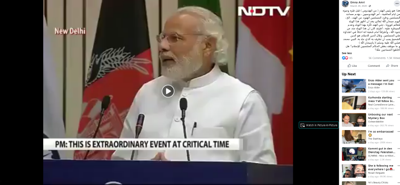

'--------------------------------------------------'

'Results:'

KeyError: '/home/runner/work/AMMICO/AMMICO/ammico/data/test-crop-image.png'

In [45]:
my_obj.show_results(
    search_query[3], # you can change the index to see the results for other queries
)

### Improve the search results

For even better results, a slightly different approach has been prepared that can improve search results. It is quite resource-intensive, so it is applied after the main algorithm has found the most relevant images. This approach works only with text queries and it skips image queries. Among the parameters you can choose 3 models: `"blip_base"`, `"blip_large"`, `"blip2_coco"`. If you get an `Out of Memory` error, try reducing the batch_size value (minimum = 1), which is the number of images being processed simultaneously. With the parameter `need_grad_cam = True/False` you can enable the calculation of the heat map of each image to be processed and save them in `image_gradcam_with_itm`. Thus the `image_text_match_reordering()` function calculates new similarity values and new ranks for each image. The resulting values are added to the general dictionary.

In [46]:
itm_model = "blip_base"
# itm_model = "blip_large"
# itm_model = "blip2_coco"

In [47]:
itm_scores, image_gradcam_with_itm = my_obj.image_text_match_reordering(
    search_query,
    itm_model,
    image_keys,
    sorted_lists,
    batch_size=1,
    need_grad_cam=True,
)

NameError: name 'image_keys' is not defined

Then using the same output function you can add the `itm=True` argument to output the new image order. Remember that for images querys, an error will be thrown with `itm=True` argument. You can also add the `image_gradcam_with_itm` along with `itm=True` argument to output the heat maps of the calculated images.

In [48]:
my_obj.show_results(
    search_query[0], itm=True, image_gradcam_with_itm=image_gradcam_with_itm
)

NameError: name 'image_gradcam_with_itm' is not defined

### Save search results to csv

Convert the dictionary of dictionarys into a dictionary with lists:

In [49]:
outdict = ammico.append_data_to_dict(image_dict)
df = ammico.dump_df(outdict)

AttributeError: module 'ammico' has no attribute 'append_data_to_dict'

Check the dataframe:

In [50]:
df.head(10)

NameError: name 'df' is not defined

Write the csv file:

In [51]:
df.to_csv("/content/drive/MyDrive/misinformation-data/data_out.csv")

NameError: name 'df' is not defined

## Color analysis of pictures

This module shows primary color analysis of color image using K-Means algorithm.
The output are N primary colors and their corresponding percentage.

To check the analysis, you can inspect the analyzed elements here. Loading the results takes a moment, so please be patient. If you are sure of what you are doing, you can skip this and directly export a csv file in the step below.
Here, we display the color detection results provided by `colorgram` and `colour` libraries. Click on the tabs to see the results in the right sidebar. You may need to increment the `port` number if you are already running several notebook instances on the same server.

In [52]:
analysis_explorer = ammico.AnalysisExplorer(image_dict)
analysis_explorer.run_server(port = 8057)

Instead of inspecting each of the images, you can also directly carry out the analysis and export the result into a csv. This may take a while depending on how many images you have loaded.

In [53]:
for key in image_dict.keys():
    image_dict[key] = ammico.colors.ColorDetector(image_dict[key]).analyse_image()

These steps are required to convert the dictionary of dictionarys into a dictionary with lists, that can be converted into a pandas dataframe and exported to a csv file.

In [54]:
df = ammico.get_dataframe(image_dict)

Check the dataframe:

In [55]:
df.head(10)

,filename,face,multiple_faces,no_faces,wears_mask,age,gender,race,emotion,emotion (category),...,blue,yellow,cyan,orange,purple,pink,brown,grey,white,black
0,data-test/img4.png,No,No,0,[No],[None],[None],[None],[None],[None],...,0.16,0.00,0,0,0.00,0,0.10,0.42,0.05,0.21
1,data-test/img1.png,No,No,0,[No],[None],[None],[None],[None],[None],...,0.00,0.00,0,0,0.00,0,0.00,0.96,0.00,0.04
2,data-test/img2.png,No,No,0,[No],[None],[None],[None],[None],[None],...,0.00,0.75,0,0,0.00,0,0.04,0.15,0.00,0.02
3,data-test/img3.png,No,No,0,[No],[None],[None],[None],[None],[None],...,0.00,0.00,0,0,0.02,0,0.06,0.92,0.01,0.00
4,data-test/img0.png,No,No,0,[No],[None],[None],[None],[None],[None],...,0.00,0.00,0,0,0.00,0,0.00,0.98,0.00,0.02
5,data-test/img5.png,Yes,No,1,[No],[26],[Man],[None],[sad],[Negative],...,0.12,0.00,0,0,0.00,0,0.02,0.50,0.00,0.00


Write the csv file - here you should provide a file path and file name for the csv file to be written.

In [56]:
df.to_csv("/content/drive/MyDrive/misinformation-data/data_out.csv")

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/misinformation-data'

## Further detector modules
Further detector modules exist, also it is possible to carry out a topic analysis on the text data, as well as crop social media posts automatically. These are more experimental features and have their own demonstration notebooks.